# HW4: Return Predictions From Trade Flow

Jack Mansfield

12407052

# 1) Introduction


in this strategy I will assess trade flow as means of generating profit opportunities in 3 cryptotoken markets. I 
stress the word “opportunity” because at high data rates like these, and given the markets’ price-time
priority, it is far easier to identify desirable trades in the data stream than it is to inject oneself profitably
into the fray.


I will do so by calulating the flow indicator, running a regession of it against future returns, and then backtesting the resulting predicted values to trade when they idicate a profitable trade

### Import dependencies and init globals

In [414]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.preprocessing import StandardScaler
import pandas_market_calendars as mcal
import numpy as np
import scipy as sp
import math
from math import floor
import functools
import seaborn as sns

import copy

from plotnine import ggplot, aes, geom_line, geom_hline, labs, theme, element_text, geom_area, scale_fill_manual, geom_bar

import os
from datetime import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm

from enum import Enum

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2) Data

In [415]:
# Specfify file Paths
file_path_1 = r'Crypto\2023\book_narrow_BTC-USD_2023.delim\book_narrow_BTC-USD_2023.delim'  # Update this to the actual path of your file
file_path_2 = r'Crypto\2023\trades_narrow_BTC-USD_2023.delim\trades_narrow_BTC-USD_2023.delim'  # Update this to the actual path of your file

# Read the data into a DataFrame, specifying the tab delimiter
BTC_USD_book_raw = pd.read_csv(file_path_1, sep='\t')
BTC_USD_trades_raw = pd.read_csv(file_path_2, sep='\t')

# Convert timestamps to datetime format
BTC_USD_book_raw['timestamp_utc_nanoseconds'] = pd.to_datetime(BTC_USD_book_raw['timestamp_utc_nanoseconds'], unit='ns')
BTC_USD_book_raw['received_utc_nanoseconds'] = pd.to_datetime(BTC_USD_book_raw['received_utc_nanoseconds'], unit='ns')
BTC_USD_trades_raw['timestamp_utc_nanoseconds'] = pd.to_datetime(BTC_USD_trades_raw['timestamp_utc_nanoseconds'], unit='ns')
BTC_USD_trades_raw['received_utc_nanoseconds'] = pd.to_datetime(BTC_USD_trades_raw['received_utc_nanoseconds'], unit='ns')


# Display the first few rows to verify
display(BTC_USD_book_raw.head())
display(BTC_USD_trades_raw.head())



,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds,Mid
0,22972550000,22970150000,210000000,25797600,22972560000,22970120000,210000000,87069610,2023-01-24 00:47:47.750919800,2023-01-24 00:47:47.806932,2.297135e+10
1,22972550000,22970150000,410000000,25797600,22972560000,22970120000,210000000,87069610,2023-01-24 00:47:47.751154000,2023-01-24 00:47:47.807073,2.297135e+10
2,22972550000,22970150000,410000000,25797600,22972560000,22970120000,210000000,87069610,2023-01-24 00:47:47.752363000,2023-01-24 00:47:47.813516,2.297135e+10
3,22972540000,22970150000,210000000,25797600,22972550000,22970120000,410000000,87069610,2023-01-24 00:47:47.763308000,2023-01-24 00:47:47.819272,2.297134e+10
4,22972540000,22970150000,210000000,25797600,22972550000,22970120000,410000000,87069610,2023-01-24 00:47:47.764161000,2023-01-24 00:47:47.825538,2.297134e+10


,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,2023-01-24 00:47:47.814309,2023-01-24 00:47:47.874527,22970120000,87069600,-1
1,2023-01-24 00:47:47.814046,2023-01-24 00:47:47.874527,22970150000,25797600,-1
2,2023-01-24 00:47:47.817981,2023-01-24 00:47:47.878712,22970120000,10,-1
3,2023-01-24 00:47:47.822734,2023-01-24 00:47:47.886114,22969160000,217683140,-1
4,2023-01-24 00:47:54.845338,2023-01-24 00:47:48.676444,22969840000,10000000,1


In [416]:
# Specfify file Paths
file_path_1 = r'Crypto\2023\book_narrow_ETH-BTC_2023.delim\book_narrow_ETH-BTC_2023.delim'  # Update this to the actual path of your file
file_path_2 = r'Crypto\2023\trades_narrow_ETH-BTC_2023.delim\trades_narrow_ETH-BTC_2023.delim'  # Update this to the actual path of your file

# Read the data into a DataFrame, specifying the tab delimiter
ETH_BTC_book_raw = pd.read_csv(file_path_1, sep='\t')
ETH_BTC_trades_raw = pd.read_csv(file_path_2, sep='\t')

# Convert timestamps to datetime format
ETH_BTC_book_raw['timestamp_utc_nanoseconds'] = pd.to_datetime(ETH_BTC_book_raw['timestamp_utc_nanoseconds'], unit='ns')
ETH_BTC_book_raw['received_utc_nanoseconds'] = pd.to_datetime(ETH_BTC_book_raw['received_utc_nanoseconds'], unit='ns')
ETH_BTC_trades_raw['timestamp_utc_nanoseconds'] = pd.to_datetime(ETH_BTC_trades_raw['timestamp_utc_nanoseconds'], unit='ns')
ETH_BTC_trades_raw['received_utc_nanoseconds'] = pd.to_datetime(ETH_BTC_trades_raw['received_utc_nanoseconds'], unit='ns')

# Display the first few rows to verify
display(ETH_BTC_book_raw.head())
display(ETH_BTC_trades_raw.head())


,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds,Mid
0,70970,70940,2297617430,48603840,70980,70930,13399602090,14206845420,2023-01-24 00:47:55.893722000,2023-01-24 00:47:55.066931,70955.0
1,70970,70940,2297617430,48603840,70980,70930,13399602090,14206845420,2023-01-24 00:47:58.094853200,2023-01-24 00:47:58.159732,70955.0
2,70970,70940,2297617430,48603840,70980,70930,13399602090,14996845420,2023-01-24 00:47:58.106928800,2023-01-24 00:47:58.171531,70955.0
3,70970,70940,1507617430,48603840,70980,70930,10629602090,14996845420,2023-01-24 00:47:58.108897000,2023-01-24 00:47:58.173961,70955.0
4,70970,70940,1507617430,48603840,70980,70930,10629602090,14996845420,2023-01-24 00:47:58.122113000,2023-01-24 00:47:58.183694,70955.0


,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,2023-01-24 00:49:05.955989,2023-01-24 00:49:06.020758,70950,259656510,1
1,2023-01-24 00:49:05.984460,2023-01-24 00:49:06.050573,70950,140800,1
2,2023-01-24 00:49:08.097555,2023-01-24 00:49:08.159815,70950,53582550,-1
3,2023-01-24 00:49:12.535174,2023-01-24 00:49:12.601911,70940,207220,-1
4,2023-01-24 00:52:26.128872,2023-01-24 00:52:26.201920,70950,990630,1


In [417]:
# Specfify file Paths
file_path_1 = r'Crypto\2023\book_narrow_ETH-USD_2023.delim\book_narrow_ETH-USD_2023.delim'  # Update this to the actual path of your file
file_path_2 = r'Crypto\2023\trades_narrow_ETH-USD_2023.delim\trades_narrow_ETH-USD_2023.delim'  # Update this to the actual path of your file

# Read the data into a DataFrame, specifying the tab delimiter
ETH_USD_book_raw = pd.read_csv(file_path_1, sep='\t')
ETH_USD_trades_raw = pd.read_csv(file_path_2, sep='\t')

# Convert timestamps to datetime format
ETH_USD_book_raw['timestamp_utc_nanoseconds'] = pd.to_datetime(ETH_USD_book_raw['timestamp_utc_nanoseconds'], unit='ns')
ETH_USD_book_raw['received_utc_nanoseconds'] = pd.to_datetime(ETH_USD_book_raw['received_utc_nanoseconds'], unit='ns')
ETH_USD_trades_raw['timestamp_utc_nanoseconds'] = pd.to_datetime(ETH_USD_trades_raw['timestamp_utc_nanoseconds'], unit='ns')
ETH_USD_trades_raw['received_utc_nanoseconds'] = pd.to_datetime(ETH_USD_trades_raw['received_utc_nanoseconds'], unit='ns')

# Display the first few rows to verify
display(ETH_USD_book_raw.head())
display(ETH_USD_trades_raw.head())


,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds,Mid
0,1629780000,1629670000,613579740,46580250,1629790000,1629660000,920369620,40425010,2023-01-24 00:47:55.215127,2023-01-24 00:47:51.006006,1.629725e+09
1,1629780000,1629670000,613579740,46580250,1629790000,1629660000,920369620,125425010,2023-01-24 00:47:55.215372,2023-01-24 00:47:51.008923,1.629725e+09
2,1629780000,1629670000,613579740,346580250,1629790000,1629660000,920369620,125425010,2023-01-24 00:47:55.216940,2023-01-24 00:47:51.013030,1.629725e+09
3,1629780000,1629670000,613579740,334765040,1629790000,1629660000,920369620,125425010,2023-01-24 00:47:55.236165,2023-01-24 00:47:51.071902,1.629725e+09
4,1629770000,1629670000,92158690,334765040,1629780000,1629660000,613579740,125425010,2023-01-24 00:47:55.257733,2023-01-24 00:47:51.167792,1.629720e+09


,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,2023-01-24 00:47:55.236165,2023-01-24 00:47:51.071902,1629670000,11815210,-1
1,2023-01-24 00:47:55.287511,2023-01-24 00:47:51.398509,1629770000,92158690,1
2,2023-01-24 00:47:55.288004,2023-01-24 00:47:51.398509,1629780000,712594890,2
3,2023-01-24 00:47:55.288470,2023-01-24 00:47:51.398509,1629790000,1016994240,2
4,2023-01-24 00:47:55.330683,2023-01-24 00:47:51.578052,1629770000,92150000,1


### 2.0) Data Cleaning 

In [418]:
# Save checkpoint
BTC_USD_book = BTC_USD_book_raw
BTC_USD_trades = BTC_USD_trades_raw

ETH_USD_book = ETH_USD_book_raw
ETH_USD_trades = ETH_USD_trades_raw

ETH_BTC_book = ETH_BTC_book_raw
ETH_BTC_trades = ETH_BTC_trades_raw

#### Helper Functions

In [419]:
# Define a function to process the DataFrame
def process_and_set_index(df, column_name):
    """
    Checks if the specified column in the DataFrame contains only unique values,
    sorts the DataFrame by that column, and sets the column as the DataFrame's index
    if it is unique.
    
    Parameters:
    - df: pandas.DataFrame to process
    - column_name: str, the name of the column to check for uniqueness and set as index
    
    Returns:
    - The processed DataFrame with the column set as index if unique.
    """
    # Check if the column contains only unique values
    is_unique = df[column_name].is_unique
    print(f"Is the {column_name} column unique?", is_unique)
    
    # Sort the DataFrame by the specified column
    df_sorted = df.sort_values(by=column_name)
    
    # If unique, set the column as the index
    if is_unique:
        df_sorted.set_index(column_name, inplace=True)
        print("Column set as index.")
    else:
        print("Column contains duplicates; not set as index.")
    
    return df_sorted

def process_dataframe_and_adjust_size(df, index_columns):
    """
    Processes the DataFrame by setting a multi-index, sorting by the multi-index, adjusting the 'size' column
    based on the 'side' column, and then removing the 'side' column.
    
    Parameters:
    - df: pandas.DataFrame to process
    - index_columns: list of str, column names to set as multi-index
    
    Returns:
    - The processed DataFrame with a multi-index, sorted by the multi-index, and with adjusted 'size' column.
    """
    # Set the multi-index
    df.set_index(index_columns, inplace=True)

    # Adjust the 'size' column based on the 'side' column
    # Assuming 'side' column contains numeric values that indicate multiplication factor
    df['size'] = df['size'] * df['side']

    # Remove the 'side' column
    df.drop(columns=['side'], inplace=True)

    # Sort the DataFrame by the new multi-index
    df.sort_index(inplace=True)
    
    return df

def check_dataframe_integrity(df, set_0 = False):
    """
    Performs integrity checks on a pandas DataFrame, including checks for excessively large numbers,
    NaN values, and more. Results of checks are printed along with details on excessively large numbers
    and NaN values. Finally, all NaN values are filled with 0.0.

    Parameters:
    - df: pandas.DataFrame to check
    """
    # Flag to indicate if any excessively large numbers were found
    found_excessive_numbers = False
    
    # Check for excessively large numbers and print them
    for column in df.select_dtypes(include=[np.number]).columns:
        excessive_values = df[df[column] > 1e9][column]
        if not excessive_values.empty:
            found_excessive_numbers = True
            print(f"Excessively large numbers found in column '{column}':")
            print(excessive_values.to_string(), "\n")
    
    if not found_excessive_numbers:
        print("Check for excessively large numbers: Passed")
    
    # Initial check for any NaN values
    total_nan_count = df.isnull().sum().sum()
    if total_nan_count > 0:
        print("Check for NaN values: Found. Detailed report follows.")
    else:
        print("Check for NaN values: Passed")

    # Detailed NaN values report
    for column in df.columns:
        nan_count = df[column].isnull().sum()
        if nan_count > 0:
            percent_nan = (nan_count / len(df)) * 100
            print(f"Column '{column}' has {nan_count} NaN value(s), which is {percent_nan:.2f}% of the rows.")
    
    if set_0:
        # Fill all NaN values with 0.0
        print("Filling all NaN values with 0.0")
        df.fillna(0.0, inplace=True)


#### Clean Order Book Data

In [420]:
# Drop unesscary Columns
BTC_USD_book = BTC_USD_book.drop(['Ask2PriceMillionths', 'Bid2PriceMillionths', 'Ask2SizeBillionths', 'Bid2SizeBillionths', 'received_utc_nanoseconds'], axis=1)
ETH_USD_book = ETH_USD_book.drop(['Ask2PriceMillionths', 'Bid2PriceMillionths', 'Ask2SizeBillionths', 'Bid2SizeBillionths', 'received_utc_nanoseconds'], axis=1)
ETH_BTC_book = ETH_BTC_book.drop(['Ask2PriceMillionths', 'Bid2PriceMillionths', 'Ask2SizeBillionths', 'Bid2SizeBillionths', 'received_utc_nanoseconds'], axis=1)

# Rescale price data
BTC_USD_book['Ask1PriceMillionths'] = BTC_USD_book['Ask1PriceMillionths'] / 1000000.0
ETH_USD_book['Ask1PriceMillionths'] = ETH_USD_book['Ask1PriceMillionths'] / 1000000.0
ETH_BTC_book['Ask1PriceMillionths'] = ETH_BTC_book['Ask1PriceMillionths'] / 1000000.0

BTC_USD_book['Bid1PriceMillionths'] = BTC_USD_book['Bid1PriceMillionths'] / 1000000.0
ETH_USD_book['Bid1PriceMillionths'] = ETH_USD_book['Bid1PriceMillionths'] / 1000000.0
ETH_BTC_book['Bid1PriceMillionths'] = ETH_BTC_book['Bid1PriceMillionths'] / 1000000.0

# Rescale size data
BTC_USD_book['Ask1SizeBillionths'] = BTC_USD_book['Ask1SizeBillionths'] / 1000000000.0
ETH_USD_book['Ask1SizeBillionths'] = ETH_USD_book['Ask1SizeBillionths'] / 1000000000.0
ETH_BTC_book['Ask1SizeBillionths'] = ETH_BTC_book['Ask1SizeBillionths'] / 1000000000.0

BTC_USD_book['Bid1SizeBillionths'] = BTC_USD_book['Bid1SizeBillionths'] / 1000000000.0
ETH_USD_book['Bid1SizeBillionths'] = ETH_USD_book['Bid1SizeBillionths'] / 1000000000.0
ETH_BTC_book['Bid1SizeBillionths'] = ETH_BTC_book['Bid1SizeBillionths'] / 1000000000.0

# Rescale mid data
BTC_USD_book['Mid'] = BTC_USD_book['Mid'] / 1000000.0
ETH_USD_book['Mid'] = ETH_USD_book['Mid'] / 1000000.0
ETH_BTC_book['Mid'] = ETH_BTC_book['Mid'] / 1000000.0


# Rename columns
BTC_USD_book = BTC_USD_book.rename(columns={'timestamp_utc_nanoseconds': 'time', 'Mid': 'mid', 'Ask1PriceMillionths': 'ask_price', 'Bid1PriceMillionths': 'bid_price', 'Ask1SizeBillionths': 'ask_size', 'Bid1SizeBillionths':'bid_size'})
ETH_USD_book = ETH_USD_book.rename(columns={'timestamp_utc_nanoseconds': 'time', 'Mid': 'mid', 'Ask1PriceMillionths': 'ask_price', 'Bid1PriceMillionths': 'bid_price', 'Ask1SizeBillionths': 'ask_size', 'Bid1SizeBillionths':'bid_size'})
ETH_BTC_book = ETH_BTC_book.rename(columns={'timestamp_utc_nanoseconds': 'time', 'Mid': 'mid', 'Ask1PriceMillionths': 'ask_price', 'Bid1PriceMillionths': 'bid_price', 'Ask1SizeBillionths': 'ask_size', 'Bid1SizeBillionths':'bid_size'})

# Set indicies and sort
BTC_USD_book = process_and_set_index(BTC_USD_book, 'time')
ETH_USD_book = process_and_set_index(ETH_USD_book, 'time')
ETH_BTC_book = process_and_set_index(ETH_BTC_book, 'time')

check_dataframe_integrity(BTC_USD_book)
check_dataframe_integrity(ETH_USD_book)
check_dataframe_integrity(ETH_BTC_book)


# Display the head of each DataFrame to verify the operation
display(BTC_USD_book.head())
display(ETH_USD_book.head())
display(ETH_BTC_book.head())

Is the time column unique? True
Column set as index.
Is the time column unique? True
Column set as index.
Is the time column unique? True
Column set as index.
Check for excessively large numbers: Passed
Check for NaN values: Passed
Check for excessively large numbers: Passed
Check for NaN values: Passed
Check for excessively large numbers: Passed
Check for NaN values: Passed


,ask_price,bid_price,ask_size,bid_size,mid
time,,,,,
2023-01-24 00:47:47.806932,22972.55,22970.15,0.21,0.025798,22971.350
2023-01-24 00:47:47.807073,22972.55,22970.15,0.41,0.025798,22971.350
2023-01-24 00:47:47.813516,22972.55,22970.15,0.41,0.025798,22971.350
2023-01-24 00:47:47.819272,22972.54,22970.15,0.21,0.025798,22971.345
2023-01-24 00:47:47.825538,22972.54,22970.15,0.21,0.025798,22971.345


,ask_price,bid_price,ask_size,bid_size,mid
time,,,,,
2023-01-24 00:47:51.006006,1629.78,1629.67,0.613580,0.046580,1629.725
2023-01-24 00:47:51.008923,1629.78,1629.67,0.613580,0.046580,1629.725
2023-01-24 00:47:51.013030,1629.78,1629.67,0.613580,0.346580,1629.725
2023-01-24 00:47:51.071902,1629.78,1629.67,0.613580,0.334765,1629.725
2023-01-24 00:47:51.167792,1629.77,1629.67,0.092159,0.334765,1629.720


,ask_price,bid_price,ask_size,bid_size,mid
time,,,,,
2023-01-24 00:47:55.066931,0.07097,0.07094,2.297617,0.048604,0.070955
2023-01-24 00:47:58.159732,0.07097,0.07094,2.297617,0.048604,0.070955
2023-01-24 00:47:58.171531,0.07097,0.07094,2.297617,0.048604,0.070955
2023-01-24 00:47:58.173961,0.07097,0.07094,1.507617,0.048604,0.070955
2023-01-24 00:47:58.183694,0.07097,0.07094,1.507617,0.048604,0.070955


#### Clean Trade Book Data

In [421]:
# Drop unesscary Columns
BTC_USD_trades = BTC_USD_trades.drop(['received_utc_nanoseconds'], axis=1)
ETH_USD_trades = ETH_USD_trades.drop(['received_utc_nanoseconds'], axis=1)
ETH_BTC_trades = ETH_BTC_trades.drop(['received_utc_nanoseconds'], axis=1)


# Rescale price data
BTC_USD_trades['PriceMillionths'] = BTC_USD_trades['PriceMillionths'] / 1000000.0
ETH_USD_trades['PriceMillionths'] = ETH_USD_trades['PriceMillionths'] / 1000000.0
ETH_BTC_trades['PriceMillionths'] = ETH_BTC_trades['PriceMillionths'] / 1000000.0

# Rescale size data
BTC_USD_trades['SizeBillionths'] = BTC_USD_trades['SizeBillionths'] / 1000000000.0
ETH_USD_trades['SizeBillionths'] = ETH_USD_trades['SizeBillionths'] / 1000000000.0
ETH_BTC_trades['SizeBillionths'] = ETH_BTC_trades['SizeBillionths'] / 1000000000.


# Rename columns
BTC_USD_trades = BTC_USD_trades.rename(columns={'timestamp_utc_nanoseconds': 'time','Side': 'side','PriceMillionths': 'price', 'SizeBillionths': 'size'})
ETH_USD_trades = ETH_USD_trades.rename(columns={'timestamp_utc_nanoseconds': 'time','Side': 'side','PriceMillionths': 'price', 'SizeBillionths': 'size'})
ETH_BTC_trades = ETH_BTC_trades.rename(columns={'timestamp_utc_nanoseconds': 'time','Side': 'side','PriceMillionths': 'price', 'SizeBillionths': 'size'})

# Set indicies and sort 
BTC_USD_trades = process_dataframe_and_adjust_size(BTC_USD_trades, ['time'])
ETH_USD_trades = process_dataframe_and_adjust_size(ETH_USD_trades, ['time'])
ETH_BTC_trades = process_dataframe_and_adjust_size(ETH_BTC_trades, ['time'])

check_dataframe_integrity(BTC_USD_trades)
check_dataframe_integrity(ETH_USD_trades)
check_dataframe_integrity(ETH_BTC_book)

# Display the head of each DataFrame to verify the operation
display(BTC_USD_trades.head())
display(ETH_USD_trades.head())
display(ETH_BTC_trades.head())


Check for excessively large numbers: Passed
Check for NaN values: Passed
Check for excessively large numbers: Passed
Check for NaN values: Passed
Check for excessively large numbers: Passed
Check for NaN values: Passed


,price,size
time,,
2023-01-24 00:47:47.874527,22970.12,-8.706960e-02
2023-01-24 00:47:47.874527,22970.15,-2.579760e-02
2023-01-24 00:47:47.878712,22970.12,-1.000000e-08
2023-01-24 00:47:47.886114,22969.16,-2.176831e-01
2023-01-24 00:47:48.676444,22969.84,1.000000e-02


,price,size
time,,
2023-01-24 00:47:51.071902,1629.67,-0.011815
2023-01-24 00:47:51.398509,1629.77,0.092159
2023-01-24 00:47:51.398509,1629.78,1.425190
2023-01-24 00:47:51.398509,1629.79,2.033988
2023-01-24 00:47:51.578052,1629.77,0.092150


,price,size
time,,
2023-01-24 00:49:06.020758,0.07095,0.259657
2023-01-24 00:49:06.050573,0.07095,0.000141
2023-01-24 00:49:08.159815,0.07095,-0.053583
2023-01-24 00:49:12.601911,0.07094,-0.000207
2023-01-24 00:52:26.201920,0.07095,0.000991


### Lets have a look at our price series

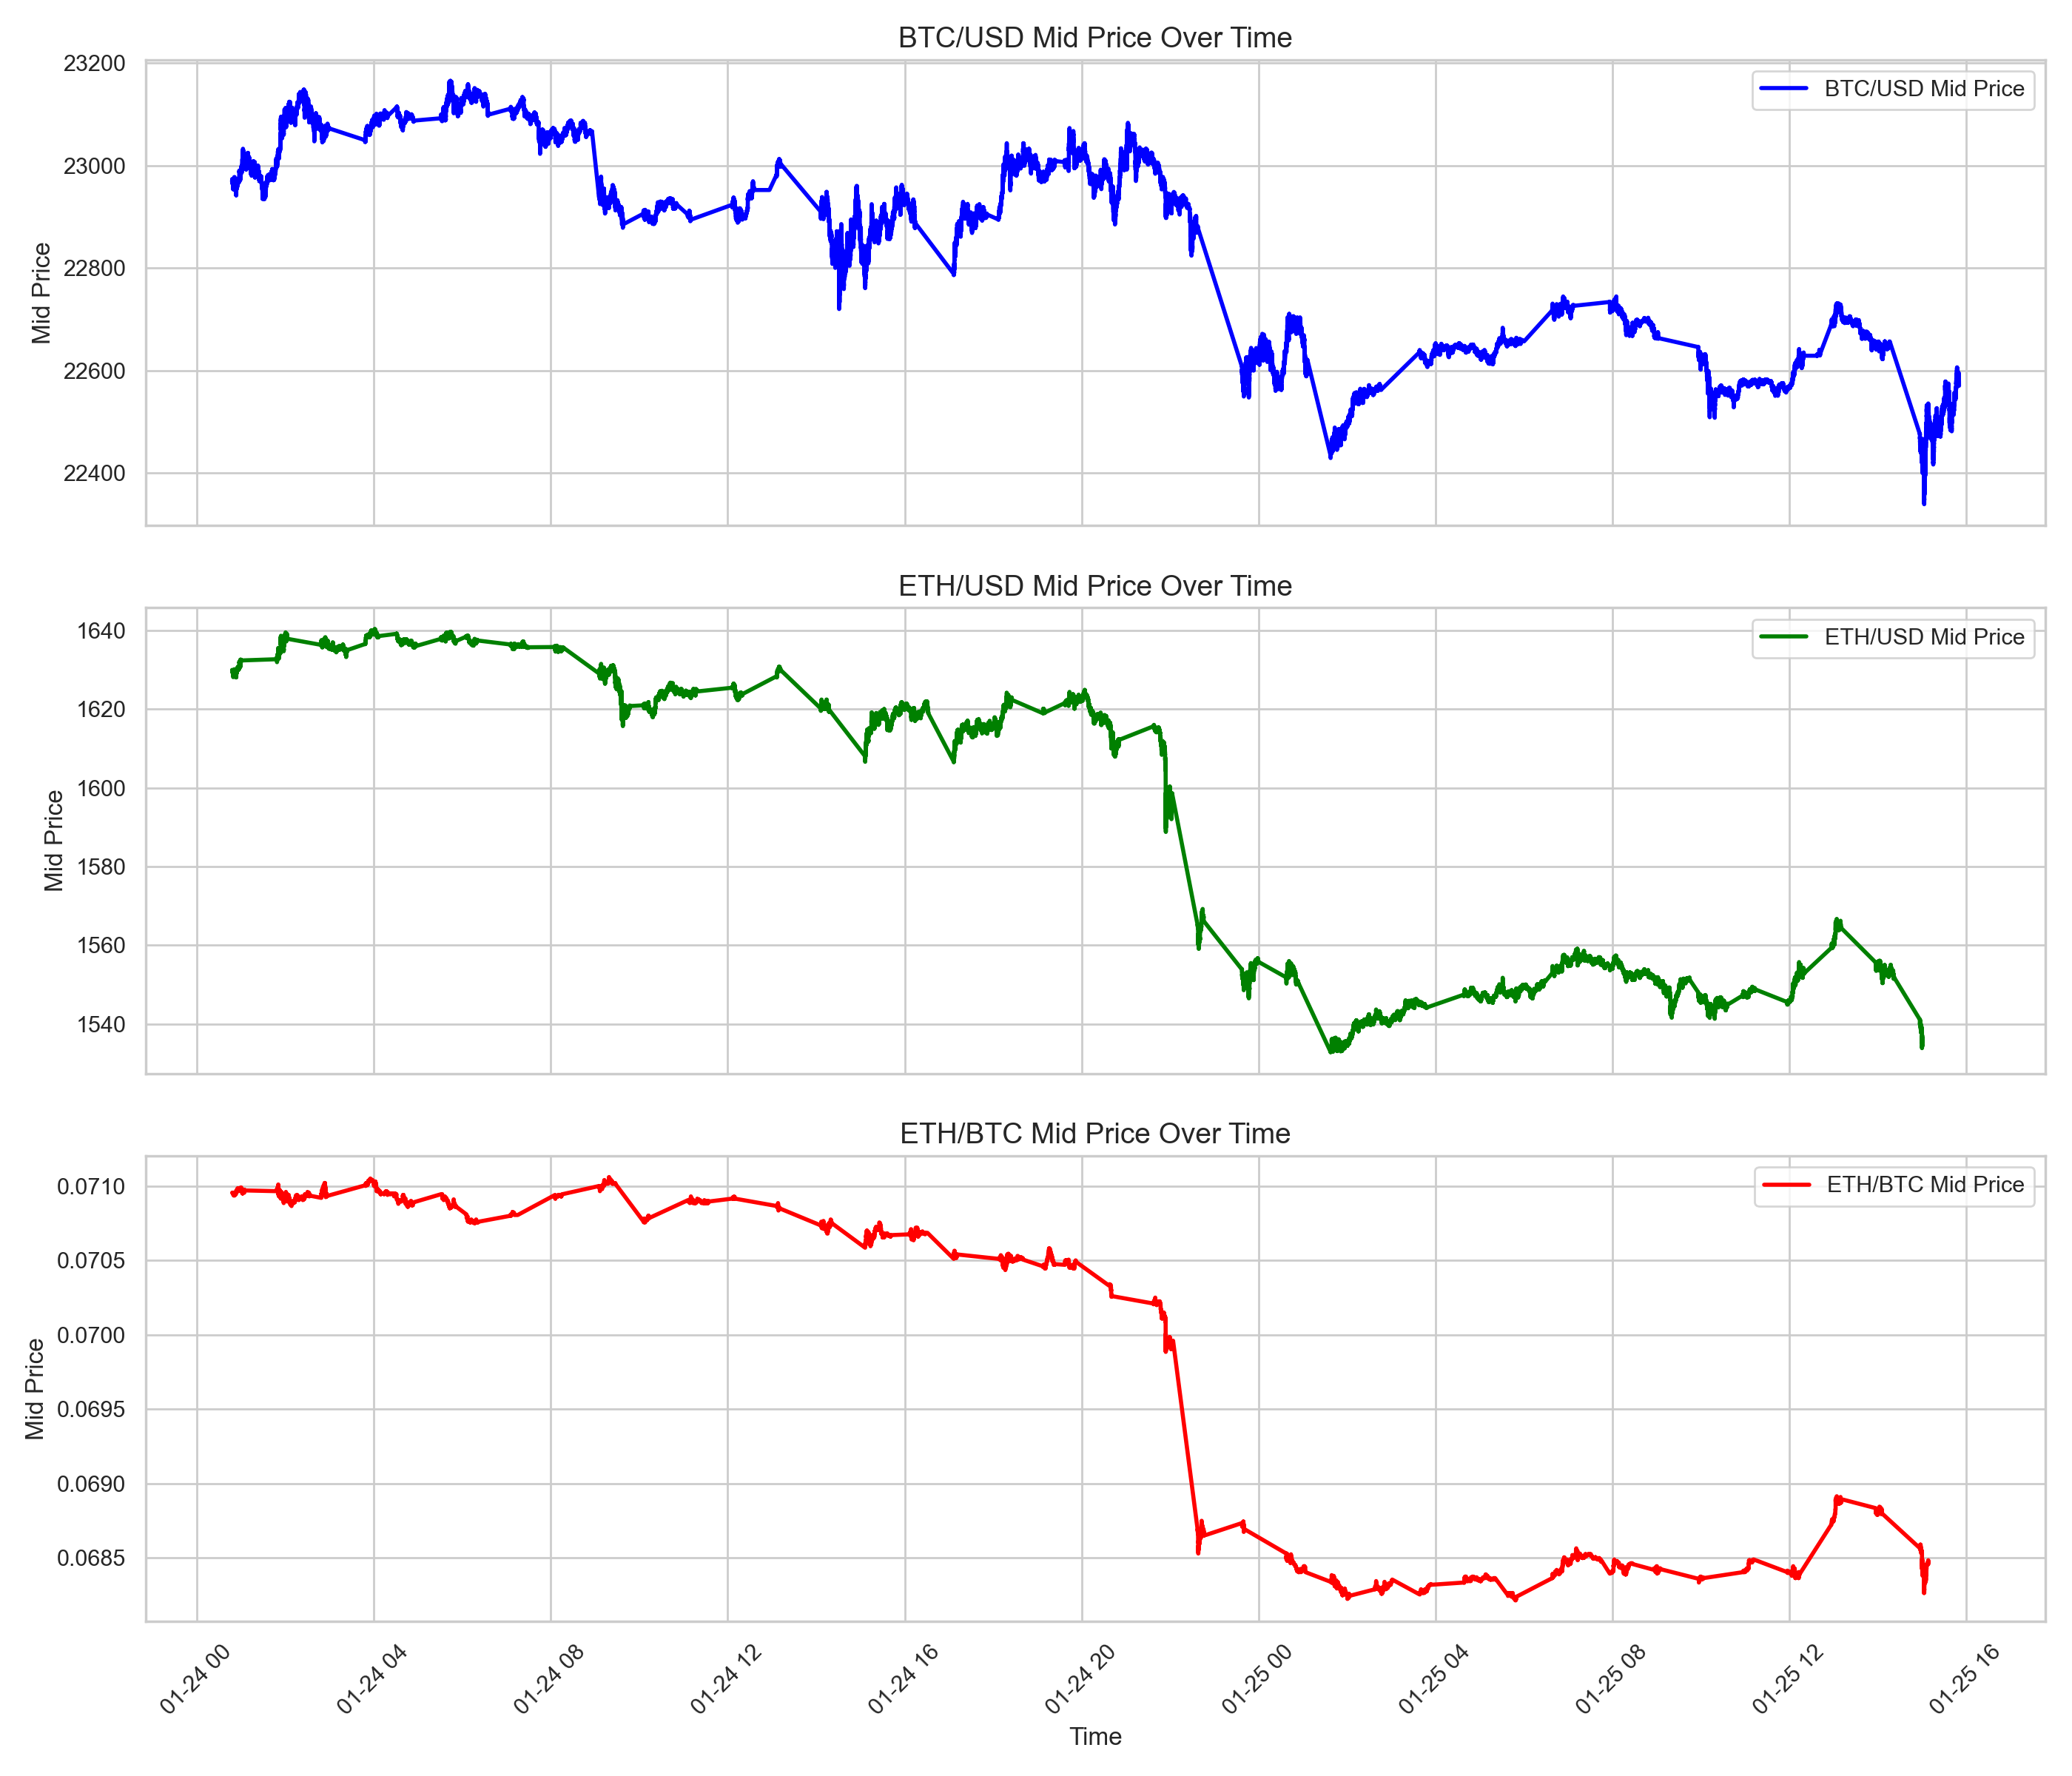

In [422]:

# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Create a figure to host the plots
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Define colors for each plot for consistency
colors = {'BTC_USD_book': 'blue', 'ETH_USD_book': 'green', 'ETH_BTC_book': 'red'}

# Plotting BTC/USD Mid Price
axs[0].plot(BTC_USD_book.index, BTC_USD_book['mid'], label='BTC/USD Mid Price', color=colors['BTC_USD_book'], linewidth=2)
axs[0].set_title('BTC/USD Mid Price Over Time', fontsize=14)
axs[0].set_ylabel('Mid Price', fontsize=12)
axs[0].legend()

# Plotting ETH/USD Mid Price
axs[1].plot(ETH_USD_book.index, ETH_USD_book['mid'], label='ETH/USD Mid Price', color=colors['ETH_USD_book'], linewidth=2)
axs[1].set_title('ETH/USD Mid Price Over Time', fontsize=14)
axs[1].set_ylabel('Mid Price', fontsize=12)
axs[1].legend()

# Plotting ETH/BTC Mid Price
axs[2].plot(ETH_BTC_book.index, ETH_BTC_book['mid'], label='ETH/BTC Mid Price', color=colors['ETH_BTC_book'], linewidth=2)
axs[2].set_title('ETH/BTC Mid Price Over Time', fontsize=14)
axs[2].set_ylabel('Mid Price', fontsize=12)
axs[2].set_xlabel('Time', fontsize=12)
axs[2].legend()

# Fine-tune figure; hide x ticks for top plots and rotate labels for readability
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout(h_pad=2.0)

# Show plot
plt.show()

They seem to be a bit choppy Indicating missing data at times, But this is the data we have

##### Save Checkpoint

In [423]:
BTC_USD_book_tmp = BTC_USD_book.copy()
BTC_USD_trades_tmp = BTC_USD_trades.copy()

ETH_USD_book_tmp = ETH_USD_book.copy()
ETH_USD_trades_tmp = ETH_USD_trades.copy()

ETH_BTC_book_tmp = ETH_BTC_book.copy()
ETH_BTC_trades_tmp = ETH_BTC_trades.copy()

In [424]:
BTC_USD_book = BTC_USD_book_tmp
BTC_USD_trades = BTC_USD_trades_tmp

ETH_USD_book = ETH_USD_book_tmp
ETH_USD_trades = ETH_USD_trades_tmp

ETH_BTC_book = ETH_BTC_book_tmp
ETH_BTC_trades = ETH_BTC_trades_tmp

### 2.1) Treatment

for each pair I will be spliting my data into traning(60%) and test sets(40%). The taining set will be used to train the regression of flow vs future returns and calulate a beta which I will later use to produce my signal values in the testing set.

I split before calualting any statistics so I minimize any information bleed into the test set

In [425]:
def split_and_filter_dataframes(book_df, trades_df, name, display_data=False):
    # Adjust the split point to 60% for training data
    split_point = floor(len(book_df) * 0.6)
    book_train = book_df.iloc[:split_point].copy()
    book_test = book_df.iloc[split_point:].copy()

    # Determine the date range for the book test dataset
    test_date_start = book_test.index.min()
    test_date_end = book_test.index.max()

    # Filter the trades DataFrame based on the book test date range
    trades_test = trades_df.loc[(trades_df.index.get_level_values(0) >= test_date_start) & 
                                (trades_df.index.get_level_values(0) <= test_date_end)]
    trades_train = trades_df.loc[(trades_df.index.get_level_values(0) < test_date_start) | 
                                 (trades_df.index.get_level_values(0) > test_date_end)]

    # Integrity Checks
    # 1. Index Integrity Check
    assert book_test.index.min() > book_train.index.max(), "Overlap or gap between book test and train datasets."
    assert trades_test.index.get_level_values(0).min() > trades_train.index.get_level_values(0).max(), "Overlap or gap between trades test and train datasets."

    # 2. Data Integrity Check
    total_rows_before_split = len(book_df) + len(trades_df)
    total_rows_after_split = len(book_test) + len(book_train) + len(trades_test) + len(trades_train)
    assert total_rows_before_split == total_rows_after_split, "Data loss in splitting process."

    if display_data:
        # Display test and train splits for both book and trades
        print(f"{name} Book Train Dataset:")
        display(book_train.head())
        print(f"{name} Book Test Dataset:")
        display(book_test.head())
        print(f"{name} Trades Train Dataset:")
        display(trades_train.head())
        print(f"{name} Trades Test Dataset:")
        display(trades_test.head())
        
        # Display integrity check results
        print("Integrity checks passed. No data loss, overlaps, or gaps.")
        print()

    return book_test, book_train, trades_test, trades_train

# Example usage (ensure your DataFrame names and structures are correctly referenced)
BTC_USD_book_test, BTC_USD_book_train, BTC_USD_trades_test, BTC_USD_trades_train = split_and_filter_dataframes(BTC_USD_book, BTC_USD_trades, 'BTC_USD', True)
ETH_USD_book_test, ETH_USD_book_train, ETH_USD_trades_test, ETH_USD_trades_train = split_and_filter_dataframes(ETH_USD_book, ETH_USD_trades, 'ETH_USD', True)
ETH_BTC_book_test, ETH_BTC_book_train, ETH_BTC_trades_test, ETH_BTC_trades_train = split_and_filter_dataframes(ETH_BTC_book, ETH_BTC_trades, 'ETH_BTC', True)

BTC_USD Book Train Dataset:


,ask_price,bid_price,ask_size,bid_size,mid
time,,,,,
2023-01-24 00:47:47.806932,22972.55,22970.15,0.21,0.025798,22971.350
2023-01-24 00:47:47.807073,22972.55,22970.15,0.41,0.025798,22971.350
2023-01-24 00:47:47.813516,22972.55,22970.15,0.41,0.025798,22971.350
2023-01-24 00:47:47.819272,22972.54,22970.15,0.21,0.025798,22971.345
2023-01-24 00:47:47.825538,22972.54,22970.15,0.21,0.025798,22971.345


BTC_USD Book Test Dataset:


,ask_price,bid_price,ask_size,bid_size,mid
time,,,,,
2023-01-24 23:40:55.221790,22583.97,22580.74,0.029272,0.290523,22582.355
2023-01-24 23:40:55.222337,22583.97,22580.74,0.029272,0.290523,22582.355
2023-01-24 23:40:55.223043,22583.97,22580.74,0.029272,0.290523,22582.355
2023-01-24 23:40:55.232057,22583.97,22581.31,0.029272,0.016450,22582.640
2023-01-24 23:40:55.232482,22583.97,22581.31,0.029272,0.016450,22582.640


BTC_USD Trades Train Dataset:


,price,size
time,,
2023-01-24 00:47:47.874527,22970.12,-8.706960e-02
2023-01-24 00:47:47.874527,22970.15,-2.579760e-02
2023-01-24 00:47:47.878712,22970.12,-1.000000e-08
2023-01-24 00:47:47.886114,22969.16,-2.176831e-01
2023-01-24 00:47:48.676444,22969.84,1.000000e-02


BTC_USD Trades Test Dataset:


,price,size
time,,
2023-01-24 23:40:55.309309,22583.97,0.029270
2023-01-24 23:40:55.312544,22583.97,0.000002
2023-01-24 23:40:56.122694,22586.34,0.000130
2023-01-24 23:40:56.548699,22585.67,0.000129
2023-01-24 23:40:56.784840,22585.39,0.000067


Integrity checks passed. No data loss, overlaps, or gaps.

ETH_USD Book Train Dataset:


,ask_price,bid_price,ask_size,bid_size,mid
time,,,,,
2023-01-24 00:47:51.006006,1629.78,1629.67,0.613580,0.046580,1629.725
2023-01-24 00:47:51.008923,1629.78,1629.67,0.613580,0.046580,1629.725
2023-01-24 00:47:51.013030,1629.78,1629.67,0.613580,0.346580,1629.725
2023-01-24 00:47:51.071902,1629.78,1629.67,0.613580,0.334765,1629.725
2023-01-24 00:47:51.167792,1629.77,1629.67,0.092159,0.334765,1629.720


ETH_USD Book Test Dataset:


,ask_price,bid_price,ask_size,bid_size,mid
time,,,,,
2023-01-25 01:57:28.154446,1534.95,1534.79,0.495456,0.990000,1534.87
2023-01-25 01:57:28.163215,1534.95,1534.79,0.495456,1.185456,1534.87
2023-01-25 01:57:28.166063,1534.95,1534.79,0.495456,1.185456,1534.87
2023-01-25 01:57:28.172139,1534.95,1534.79,3.095456,1.185456,1534.87
2023-01-25 01:57:28.175154,1534.95,1534.79,0.495456,1.185456,1534.87


ETH_USD Trades Train Dataset:


,price,size
time,,
2023-01-24 00:47:51.071902,1629.67,-0.011815
2023-01-24 00:47:51.398509,1629.77,0.092159
2023-01-24 00:47:51.398509,1629.78,1.425190
2023-01-24 00:47:51.398509,1629.79,2.033988
2023-01-24 00:47:51.578052,1629.77,0.092150


ETH_USD Trades Test Dataset:


,price,size
time,,
2023-01-25 01:57:28.967754,1534.97,2.072756
2023-01-25 01:57:28.980328,1535.04,5.042325
2023-01-25 01:57:29.456500,1535.08,1.348820
2023-01-25 01:57:29.647585,1535.08,0.000006
2023-01-25 01:57:29.647585,1535.16,0.036531


Integrity checks passed. No data loss, overlaps, or gaps.

ETH_BTC Book Train Dataset:


,ask_price,bid_price,ask_size,bid_size,mid
time,,,,,
2023-01-24 00:47:55.066931,0.07097,0.07094,2.297617,0.048604,0.070955
2023-01-24 00:47:58.159732,0.07097,0.07094,2.297617,0.048604,0.070955
2023-01-24 00:47:58.171531,0.07097,0.07094,2.297617,0.048604,0.070955
2023-01-24 00:47:58.173961,0.07097,0.07094,1.507617,0.048604,0.070955
2023-01-24 00:47:58.183694,0.07097,0.07094,1.507617,0.048604,0.070955


ETH_BTC Book Test Dataset:


,ask_price,bid_price,ask_size,bid_size,mid
time,,,,,
2023-01-24 22:43:45.726727,0.06867,0.06871,0.071518,0.093619,0.068690
2023-01-24 22:43:45.740976,0.06867,0.06871,0.271518,0.093619,0.068690
2023-01-24 22:43:45.741383,0.06866,0.06871,1.520000,0.093619,0.068685
2023-01-24 22:43:45.743084,0.06866,0.06871,1.520000,0.093619,0.068685
2023-01-24 22:43:45.752910,0.06866,0.06871,1.520000,0.093619,0.068685


ETH_BTC Trades Train Dataset:


,price,size
time,,
2023-01-24 00:49:06.020758,0.07095,0.259657
2023-01-24 00:49:06.050573,0.07095,0.000141
2023-01-24 00:49:08.159815,0.07095,-0.053583
2023-01-24 00:49:12.601911,0.07094,-0.000207
2023-01-24 00:52:26.201920,0.07095,0.000991


ETH_BTC Trades Test Dataset:


,price,size
time,,
2023-01-24 22:43:50.983417,0.06864,1.52
2023-01-24 22:43:52.681493,0.06864,1.52
2023-01-24 22:43:52.718175,0.06865,1.00
2023-01-24 22:43:52.757875,0.06865,1.30
2023-01-24 22:43:57.811269,0.06865,1.00


Integrity checks passed. No data loss, overlaps, or gaps.



Combines trades that happen at exactly the same time into one trade. only for traning data as for tesing data we want to act as if we are seeing trades in real time and react to each one

In [426]:
def combine_simultaneous_trades(df):
    """
    Combines rows with the same time index into one row per time index.
    For rows with the same time index:
    - The price is set to the last row's price in the group.
    - The size is the sum of the sizes.

    Parameters:
    - df: pandas.DataFrame with a time index, and 'price' and 'size' columns.

    Returns:
    - A new DataFrame with combined rows as described.
    """
    if not df.index.is_unique:
        # Group by the index (time), then aggregate:
        agg_funcs = {
            'price': lambda x: x.iloc[-1],  # Take the last value in the group for price
            'size': 'sum'  # Sum all sizes in the group
        }
        combined_df = df.groupby(df.index).agg(agg_funcs)
    else:
        # If the index is already unique, no need to combine rows
        combined_df = df.copy()

    return combined_df

# Assuming BTC_USD_trades_train, ETH_USD_trades_train, ETH_BTC_trades_train are defined and loaded

BTC_USD_trades_train = combine_simultaneous_trades(BTC_USD_trades_train)
ETH_USD_trades_train = combine_simultaneous_trades(ETH_USD_trades_train)
ETH_USD_trades_train = combine_simultaneous_trades(ETH_USD_trades_train)

# If you want to display the first few rows of the combined DataFrames to check the result
print("BTC_USD_trades_train_combined:")
display(BTC_USD_trades_train.head())

print("\nETH_USD_trades_train_combined:")
display(ETH_USD_trades_train.head())

print("\nETH_BTC_trades_train_combined:")
display(ETH_USD_trades_train.head())

BTC_USD_trades_train_combined:


,price,size
time,,
2023-01-24 00:47:47.874527,22970.15,-1.128672e-01
2023-01-24 00:47:47.878712,22970.12,-1.000000e-08
2023-01-24 00:47:47.886114,22969.16,-2.176831e-01
2023-01-24 00:47:48.676444,22969.90,3.805745e-01
2023-01-24 00:47:48.812951,22967.67,-1.318360e-03



ETH_USD_trades_train_combined:


,price,size
time,,
2023-01-24 00:47:51.071902,1629.67,-0.011815
2023-01-24 00:47:51.398509,1629.79,3.551337
2023-01-24 00:47:51.578052,1629.77,0.092150
2023-01-24 00:47:51.660995,1629.82,0.613560
2023-01-24 00:47:51.885174,1629.97,0.480000



ETH_BTC_trades_train_combined:


,price,size
time,,
2023-01-24 00:47:51.071902,1629.67,-0.011815
2023-01-24 00:47:51.398509,1629.79,3.551337
2023-01-24 00:47:51.578052,1629.77,0.092150
2023-01-24 00:47:51.660995,1629.82,0.613560
2023-01-24 00:47:51.885174,1629.97,0.480000


In [427]:
BTC_USD_book_train_saved = copy.deepcopy(BTC_USD_book_train)
ETH_USD_book_train_saved = copy.deepcopy(ETH_USD_book_train)
ETH_BTC_book_train_saved = copy.deepcopy(ETH_BTC_book_train)

BTC_USD_book_test_saved = copy.deepcopy(BTC_USD_book_test)
ETH_USD_book_test_saved = copy.deepcopy(ETH_USD_book_test)
ETH_BTC_book_test_saved = copy.deepcopy(ETH_BTC_book_test)

BTC_USD_trades_train_saved = copy.deepcopy(BTC_USD_trades_train)
ETH_USD_trades_train_saved = copy.deepcopy(ETH_USD_trades_train)
ETH_BTC_trades_train_saved = copy.deepcopy(ETH_BTC_trades_train)

BTC_USD_trades_test_saved = copy.deepcopy(BTC_USD_trades_test)
ETH_USD_trades_test_saved = copy.deepcopy(ETH_USD_trades_test)
ETH_BTC_trades_test_saved = copy.deepcopy(ETH_BTC_trades_test)

Reindex a book data frame such that it contians data at all the trade data frame's indicies as well

In [428]:
def reindex_and_fillna_book(book_df, trade_df):
    """
    Reindex a book data frame based on the union of its index and the trade data frame's index,
    then fill NaN values using forward fill. It includes an integrity check to ensure
    all unique indices from the trade_df are present in the book_df after reindexing.
    """
    # Compute unique indices
    irr_trade_index = trade_df.index.unique()
    irr_book_index = book_df.index.unique()
    
    # Calculate the union of indices
    union_index = irr_trade_index.union(irr_book_index)
    
    # Reindex the book data frame and forward fill NaN values
    book_df_reindexed = book_df.reindex(union_index).fillna(method='ffill')
    
    # Integrity check: Ensure all unique indices from trade_df are in the updated book_df
    missing_indices = irr_trade_index[~irr_trade_index.isin(book_df_reindexed.index)]
    if not missing_indices.empty:
        raise ValueError(f"Not all trade indices are present in the book data frame after reindexing. Missing indices: {missing_indices}")
    else:
        # If the check passes, print a success message
        print("Integrity check passed: All trade indices are present in the book data frame.")
        
    return book_df_reindexed
# Dictionary of book and trade data frames for easier processing
book_dfs = {
    'BTC_USD_book_train': BTC_USD_book_train,
    'ETH_USD_book_train': ETH_USD_book_train,
    'ETH_BTC_book_train': ETH_BTC_book_train,
    'BTC_USD_book_test': BTC_USD_book_test,
    'ETH_USD_book_test': ETH_USD_book_test,
    'ETH_BTC_book_test': ETH_BTC_book_test
}

trade_dfs = {
    'BTC_USD_trades_train': BTC_USD_trades_train,
    'ETH_USD_trades_train': ETH_USD_trades_train,
    'ETH_BTC_trades_train': ETH_BTC_trades_train,
    'BTC_USD_trades_test': BTC_USD_trades_test,
    'ETH_USD_trades_test': ETH_USD_trades_test,
    'ETH_BTC_trades_test': ETH_BTC_trades_test
}

# Process each pair of book and trade data frames and update original dataframes
for key in book_dfs.keys():
    trade_key = key.replace('book', 'trades')
    book_dfs[key] = reindex_and_fillna_book(book_dfs[key], trade_dfs[trade_key])
    # Now book_dfs[key] contains the updated DataFrame
    
# Now, update the original DataFrame variables with the modified ones
BTC_USD_book_train, ETH_USD_book_train, ETH_BTC_book_train, BTC_USD_book_test, ETH_USD_book_test, ETH_BTC_book_test = \
    book_dfs['BTC_USD_book_train'], book_dfs['ETH_USD_book_train'], book_dfs['ETH_BTC_book_train'], \
    book_dfs['BTC_USD_book_test'], book_dfs['ETH_USD_book_test'], book_dfs['ETH_BTC_book_test']

Integrity check passed: All trade indices are present in the book data frame.
Integrity check passed: All trade indices are present in the book data frame.
Integrity check passed: All trade indices are present in the book data frame.
Integrity check passed: All trade indices are present in the book data frame.
Integrity check passed: All trade indices are present in the book data frame.
Integrity check passed: All trade indices are present in the book data frame.


Add The current Mid Price to the trade data

In [429]:
# Example function to merge "mid" column from book to trades DataFrames
def add_mid_from_book_to_trades(trades_df, book_df):
    # Assuming both DataFrames are indexed by time and the indices are aligned
    # We'll join the "mid" column from the book DataFrame to the trades DataFrame
    # Ensure "mid" column exists in book_df
    if "mid" not in book_df.columns:
        print("No 'mid' column in book DataFrame.")
        return trades_df

    # Join 'mid' column to trades_df
    trades_df_with_mid = trades_df.join(book_df[['mid']], how='left')
    
    return trades_df_with_mid

# Apply the function to each pair of DataFrames
BTC_USD_trades_train = add_mid_from_book_to_trades(BTC_USD_trades_train, BTC_USD_book_train)
ETH_USD_trades_train = add_mid_from_book_to_trades(ETH_USD_trades_train, ETH_USD_book_train)
ETH_BTC_trades_train = add_mid_from_book_to_trades(ETH_BTC_trades_train, ETH_BTC_book_train)

BTC_USD_trades_test = add_mid_from_book_to_trades(BTC_USD_trades_test, BTC_USD_book_test)
ETH_USD_trades_test = add_mid_from_book_to_trades(ETH_USD_trades_test, ETH_USD_book_test)
ETH_BTC_trades_test = add_mid_from_book_to_trades(ETH_BTC_trades_test, ETH_BTC_book_test)

# Example to check one of the updated DataFrames
print(BTC_USD_trades_train.head())


                               price          size        mid
time                                                         
2023-01-24 00:47:47.874527  22970.15 -1.128672e-01  22971.310
2023-01-24 00:47:47.878712  22970.12 -1.000000e-08  22970.540
2023-01-24 00:47:47.886114  22969.16 -2.176831e-01  22969.895
2023-01-24 00:47:48.676444  22969.90  3.805745e-01  22968.660
2023-01-24 00:47:48.812951  22967.67 -1.318360e-03  22968.770


# 3) Calculate Indicators

### 3.1) Calulate Trade_Flow

The floe indicator is simple a rolling sum of the trade sizes of the past Tau seconds. I start with tau = 5 and later will optimize this

Notice how I also print the amount of NaN values this Tau produces, this relates to how much we trade and we dont want a tau which will cause us to trade too few times

In [430]:
def Calculate_Trade_Flow(trade_data, tau_list):
    # Ensure the DataFrame's index is in datetime format for time-based rolling
    trade_data.index = pd.to_datetime(trade_data.index)
    
    for tau in tau_list:
        # Convert tau seconds to a string that represents a pandas offset alias
        # Since pandas rolling window considers the current point, we don't need to adjust for inclusivity
        window_str = f'{tau}s'
        
        # Creating a column name for the flow with up to 3 significant figures for tau
        col_name = "F"#f"F_{tau:.3g}"
        
        # Use rolling with the window defined in seconds, sum the 'size' within this window
        # The rolling method is applied to the 'size' column, and the sum is calculated over the window
        trade_data[col_name] = trade_data['size'].rolling(window=window_str, closed='left').sum()
    
    return trade_data
# Assuming Calculate_Trade_Flow and check_dataframe_integrity functions are defined correctly.


# Set up data_frames with associated tau_values for each DataFrame
data_frames_with_tau = {
    'BTC_USD_trades_train': (BTC_USD_trades_train,  [5]),
    'BTC_USD_trades_test': (BTC_USD_trades_test,    [5]),
    'ETH_USD_trades_train': (ETH_USD_trades_train,  [5]),
    'ETH_USD_trades_test': (ETH_USD_trades_test,    [5]),
    'ETH_BTC_trades_train': (ETH_BTC_trades_train,  [5]),
    'ETH_BTC_trades_test': (ETH_BTC_trades_test,    [5]),
}

for name,(df,tau_values) in data_frames_with_tau.items():
    print(f"DataFrame: {name}")
    Calculate_Trade_Flow(df, tau_values)  # Assuming the first argument is the DataFrame and the second is tau_values
    check_dataframe_integrity(df, set_0=True)
    display(df.head())  # Print the first few rows of each DataFrame


DataFrame: BTC_USD_trades_train
Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 28 NaN value(s), which is 0.01% of the rows.
Filling all NaN values with 0.0


,price,size,mid,F
time,,,,
2023-01-24 00:47:47.874527,22970.15,-1.128672e-01,22971.310,0.000000
2023-01-24 00:47:47.878712,22970.12,-1.000000e-08,22970.540,-0.112867
2023-01-24 00:47:47.886114,22969.16,-2.176831e-01,22969.895,-0.112867
2023-01-24 00:47:48.676444,22969.90,3.805745e-01,22968.660,-0.330550
2023-01-24 00:47:48.812951,22967.67,-1.318360e-03,22968.770,0.050024


DataFrame: BTC_USD_trades_test
Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 43 NaN value(s), which is 0.02% of the rows.
Filling all NaN values with 0.0


,price,size,mid,F
time,,,,
2023-01-24 23:40:55.309309,22583.97,0.029270,22582.930,0.000000
2023-01-24 23:40:55.312544,22583.97,0.000002,22584.055,0.029270
2023-01-24 23:40:56.122694,22586.34,0.000130,22584.445,0.029272
2023-01-24 23:40:56.548699,22585.67,0.000129,22584.125,0.029401
2023-01-24 23:40:56.784840,22585.39,0.000067,22583.985,0.029530


DataFrame: ETH_USD_trades_train
Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 68 NaN value(s), which is 0.04% of the rows.
Filling all NaN values with 0.0


,price,size,mid,F
time,,,,
2023-01-24 00:47:51.071902,1629.67,-0.011815,1629.725,0.000000
2023-01-24 00:47:51.398509,1629.79,3.551337,1629.785,-0.011815
2023-01-24 00:47:51.578052,1629.77,0.092150,1629.760,3.539522
2023-01-24 00:47:51.660995,1629.82,0.613560,1629.790,3.631672
2023-01-24 00:47:51.885174,1629.97,0.480000,1629.890,4.245232


DataFrame: ETH_USD_trades_test
Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 82 NaN value(s), which is 0.06% of the rows.
Filling all NaN values with 0.0


,price,size,mid,F
time,,,,
2023-01-25 01:57:28.967754,1534.97,2.072756,1534.875,0.000000
2023-01-25 01:57:28.980328,1535.04,5.042325,1534.915,2.072756
2023-01-25 01:57:29.456500,1535.08,1.348820,1535.015,7.115080
2023-01-25 01:57:29.647585,1535.08,0.000006,1535.065,8.463900
2023-01-25 01:57:29.647585,1535.16,0.036531,1535.065,8.463906


DataFrame: ETH_BTC_trades_train
Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 494 NaN value(s), which is 42.84% of the rows.
Filling all NaN values with 0.0


,price,size,mid,F
time,,,,
2023-01-24 00:49:06.020758,0.07095,0.259657,0.070945,0.000000
2023-01-24 00:49:06.050573,0.07095,0.000141,0.070945,0.259657
2023-01-24 00:49:08.159815,0.07095,-0.053583,0.070950,0.259797
2023-01-24 00:49:12.601911,0.07094,-0.000207,0.070950,-0.053583
2023-01-24 00:52:26.201920,0.07095,0.000991,0.070945,0.000000


DataFrame: ETH_BTC_trades_test
Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 414 NaN value(s), which is 51.43% of the rows.
Filling all NaN values with 0.0


,price,size,mid,F
time,,,,
2023-01-24 22:43:50.983417,0.06864,1.52,0.068680,0.00
2023-01-24 22:43:52.681493,0.06864,1.52,0.068680,1.52
2023-01-24 22:43:52.718175,0.06865,1.00,0.068685,3.04
2023-01-24 22:43:52.757875,0.06865,1.30,0.068680,4.04
2023-01-24 22:43:57.811269,0.06865,1.00,0.068685,0.00


### 3.2) Calulate Forward Return

used to train our regression. this is the T second return after our tau data points. we will be testing if flow is a good indicator of this in our strategy.

Notice how I use mid price to calulate my future returns instead on trade prices as to be more accurate

In [468]:
def Calculate_Forward_Return(trade_data, book_data, T_list):
    for T in T_list:
        # Calculate the new index as trade_data index + T seconds
        new_index = trade_data.index + pd.to_timedelta(T, unit='s')

        # Reindex book_data to these new timestamps, using forward fill to handle missing timestamps
        aligned_book_data = book_data.reindex(new_index, method='ffill')

        # Calculate R_T
        col_name = "R"#f"R_{T:.3g}"
        trade_data[col_name] = (aligned_book_data['mid'].values - trade_data['price']) / trade_data['price']
    
    return trade_data

In [432]:
# Set up data_frames with associated T_values and trade data for each book DataFrame
data_frames = {
    'BTC_USD_trades_train': (BTC_USD_trades_train, BTC_USD_book_train,  [5]),
    'BTC_USD_trades_test': (BTC_USD_trades_test, BTC_USD_book_test,     [5]),
    'ETH_USD_trades_train': (ETH_USD_trades_train, ETH_USD_book_train,  [5]),
    'ETH_USD_trades_test': (ETH_USD_trades_test, ETH_USD_book_test,     [5]),
    'ETH_BTC_trades_train': (ETH_BTC_trades_train, ETH_BTC_book_train,  [5]),
    'ETH_BTC_trades_test': (ETH_BTC_trades_test, ETH_BTC_book_test,     [5]),
}

for name, (trade_df, book_df,T_values) in data_frames.items():
    Calculate_Forward_Return(trade_df, book_df, T_values)
    print(f"DataFrame: {name}")
    check_dataframe_integrity(trade_df)
    display(trade_df.head())  # Print the first few rows of each DataFrame


DataFrame: BTC_USD_trades_train
Check for excessively large numbers: Passed
Check for NaN values: Passed


,price,size,mid,F,R
time,,,,,
2023-01-24 00:47:47.874527,22970.15,-1.128672e-01,22971.310,0.000000,0.000128
2023-01-24 00:47:47.878712,22970.12,-1.000000e-08,22970.540,-0.112867,0.000129
2023-01-24 00:47:47.886114,22969.16,-2.176831e-01,22969.895,-0.112867,0.000171
2023-01-24 00:47:48.676444,22969.90,3.805745e-01,22968.660,-0.330550,0.000155
2023-01-24 00:47:48.812951,22967.67,-1.318360e-03,22968.770,0.050024,0.000252


DataFrame: BTC_USD_trades_test
Check for excessively large numbers: Passed
Check for NaN values: Passed


,price,size,mid,F,R
time,,,,,
2023-01-24 23:40:55.309309,22583.97,0.029270,22582.930,0.000000,-0.000021
2023-01-24 23:40:55.312544,22583.97,0.000002,22584.055,0.029270,-0.000035
2023-01-24 23:40:56.122694,22586.34,0.000130,22584.445,0.029272,-0.000093
2023-01-24 23:40:56.548699,22585.67,0.000129,22584.125,0.029401,-0.000079
2023-01-24 23:40:56.784840,22585.39,0.000067,22583.985,0.029530,-0.000059


DataFrame: ETH_USD_trades_train
Check for excessively large numbers: Passed
Check for NaN values: Passed


,price,size,mid,F,R
time,,,,,
2023-01-24 00:47:51.071902,1629.67,-0.011815,1629.725,0.000000,0.000114
2023-01-24 00:47:51.398509,1629.79,3.551337,1629.785,-0.011815,0.000034
2023-01-24 00:47:51.578052,1629.77,0.092150,1629.760,3.539522,0.000046
2023-01-24 00:47:51.660995,1629.82,0.613560,1629.790,3.631672,0.000015
2023-01-24 00:47:51.885174,1629.97,0.480000,1629.890,4.245232,-0.000083


DataFrame: ETH_USD_trades_test
Check for excessively large numbers: Passed
Check for NaN values: Passed


,price,size,mid,F,R
time,,,,,
2023-01-25 01:57:28.967754,1534.97,2.072756,1534.875,0.000000,0.000241
2023-01-25 01:57:28.980328,1535.04,5.042325,1534.915,2.072756,0.000195
2023-01-25 01:57:29.456500,1535.08,1.348820,1535.015,7.115080,0.000202
2023-01-25 01:57:29.647585,1535.08,0.000006,1535.065,8.463900,0.000202
2023-01-25 01:57:29.647585,1535.16,0.036531,1535.065,8.463906,0.000150


DataFrame: ETH_BTC_trades_train
Check for excessively large numbers: Passed
Check for NaN values: Passed


,price,size,mid,F,R
time,,,,,
2023-01-24 00:49:06.020758,0.07095,0.259657,0.070945,0.000000,0.00000
2023-01-24 00:49:06.050573,0.07095,0.000141,0.070945,0.259657,0.00000
2023-01-24 00:49:08.159815,0.07095,-0.053583,0.070950,0.259797,-0.00007
2023-01-24 00:49:12.601911,0.07094,-0.000207,0.070950,-0.053583,0.00007
2023-01-24 00:52:26.201920,0.07095,0.000991,0.070945,0.000000,-0.00007


DataFrame: ETH_BTC_trades_test
Check for excessively large numbers: Passed
Check for NaN values: Passed


,price,size,mid,F,R
time,,,,,
2023-01-24 22:43:50.983417,0.06864,1.52,0.068680,0.00,0.000583
2023-01-24 22:43:52.681493,0.06864,1.52,0.068680,1.52,0.000583
2023-01-24 22:43:52.718175,0.06865,1.00,0.068685,3.04,0.000437
2023-01-24 22:43:52.757875,0.06865,1.30,0.068680,4.04,0.000437
2023-01-24 22:43:57.811269,0.06865,1.00,0.068685,0.00,0.000437


### 3.3) Calulate Beta's

This beta indicates the historical relationship between flow and furutre returns and will be used to create predictions which we will trade with

In [433]:
def generate_beta_matrix(df, print = False):
    R_cols = [col for col in df.columns if col.startswith('R')]
    F_cols = [col for col in df.columns if col.startswith('F')]
    
    # Initialize a DataFrame to hold beta values
    beta_matrix = pd.DataFrame(index=R_cols, columns=F_cols)
    
    for r_col in R_cols:
        for f_col in F_cols:
            Y = df[r_col]
            X = df[[f_col]]
            X = sm.add_constant(X)  # Adds a constant term to the predictor
            model = sm.OLS(Y, X, missing='drop').fit()
            if len(model.params) > 1:  # Ensure there is a slope coefficient
                beta_matrix.loc[r_col, f_col] = float(model.params[1])
            else:
                beta_matrix.loc[r_col, f_col] = np.nan
            if print:
                display(model.summary())
    
    return beta_matrix.astype(float)

def display_heatmap_with_annotations(matrix, title):
    plt.figure(figsize=(8, 4))  # Adjusted figure size to be smaller
    ax = sns.heatmap(matrix, annot=False, cmap='coolwarm', center=0, fmt=".8f", linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(title)

    # Manually annotate each cell with the numeric value
    for i, row in enumerate(matrix.values):
        for j, val in enumerate(row):
            text = f"{val:.6f}"
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')
    
    plt.xlabel('Predictor Columns (F)')
    plt.ylabel('Response Columns (R)')
    plt.show()

def generate_r_squared_matrix(df):
    R_cols = [col for col in df.columns if col.startswith('R')]
    F_cols = [col for col in df.columns if col.startswith('F')]
    
    # Initialize a DataFrame to hold R-squared values
    r_squared_matrix = pd.DataFrame(index=R_cols, columns=F_cols)
    
    for r_col in R_cols:
        for f_col in F_cols:
            Y = df[r_col]
            X = df[[f_col]]
            X = sm.add_constant(X)  # Adds a constant term to the predictor
            model = sm.OLS(Y, X, missing='drop').fit()
            r_squared_matrix.loc[r_col, f_col] = model.rsquared
    
    return r_squared_matrix.astype(float)


In [434]:

# Assuming DataFrames BTC_USD_trades_train, ETH_USD_trades_train, ETH_BTC_trades_train are already defined
print("BTC_USD Beta Matrix:")
BTC_USD_beta = generate_beta_matrix(BTC_USD_trades_train,print = True)
print("ETH_USD Beta Matrix:")
ETH_USD_beta = generate_beta_matrix(ETH_USD_trades_train,print = True)
print("ETH_BTC Beta Matrix:")
ETH_BTC_beta = generate_beta_matrix(ETH_BTC_trades_train,print=True)

# Display the heatmaps with manual annotations
#display_heatmap_with_annotations(BTC_USD_beta, 'BTC_USD Beta Coefficients Heatmap')
#display_heatmap_with_annotations(ETH_USD_beta, 'ETH_USD Beta Coefficients Heatmap')
#display_heatmap_with_annotations(ETH_BTC_beta, 'ETH_BTC Beta Coefficients Heatmap')

# Example to display one of the beta matrices
print("BTC_USD Beta Matrix:")
display(BTC_USD_beta)

# Example to display one of the beta matrices
print("ETH_USD Beta Matrix:")
display(ETH_USD_beta)

# Example to display one of the beta matrices
print("ETH_BTC Beta Matrix:")
display(ETH_BTC_beta)


BTC_USD Beta Matrix:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1688.
Date:                Thu, 08 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:54:23   Log-Likelihood:             1.3528e+06
No. Observations:              239232   AIC:                        -2.705e+06
Df Residuals:                  239230   BIC:                        -2.705e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   1.73e-06     64.429      0.000       0.000       0.000
F          -1.054e-05   2.57e-07    -41.086      0.000    -1.1e-05      -1e-05
==============================================================================
Omnibus:                   176670.786   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4241980.247
Skew:                           3.344   Prob(JB):                         0.00
Kurtosis:                      22.515   Cond. No.                         6.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ETH_USD Beta Matrix:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     4876.
Date:                Thu, 08 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:54:23   Log-Likelihood:             1.0024e+06
No. Observations:              151645   AIC:                        -2.005e+06
Df Residuals:                  151643   BIC:                        -2.005e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.082e-05   8.38e-07     12.921      0.000    9.18e-06    1.25e-05
F            2.55e-07   3.65e-09     69.829      0.000    2.48e-07    2.62e-07
==============================================================================
Omnibus:                   137401.326   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         55587858.669
Skew:                          -3.520   Prob(JB):                         0.00
Kurtosis:                      96.531   Cond. No.                         230.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ETH_BTC Beta Matrix:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     208.7
Date:                Thu, 08 Feb 2024   Prob (F-statistic):           1.36e-43
Time:                        21:54:23   Log-Likelihood:                 6441.0
No. Observations:                1153   AIC:                        -1.288e+04
Df Residuals:                    1151   BIC:                        -1.287e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   2.79e-05     10.131      0.000       0.000       0.000
F          -1.856e-06   1.28e-07    -14.445      0.000   -2.11e-06    -1.6e-06
==============================================================================
Omnibus:                      446.167   Durbin-Watson:                   0.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1507.838
Skew:                           1.929   Prob(JB):                         0.00
Kurtosis:                       7.063   Cond. No.                         226.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

BTC_USD Beta Matrix:


,F
R,-0.000011


ETH_USD Beta Matrix:


,F
R,2.549991e-07


ETH_BTC Beta Matrix:


,F
R,-0.000002


In [435]:
def generate_r_squared_matrix(df):
    R_cols = [col for col in df.columns if col.startswith('R')]
    F_cols = [col for col in df.columns if col.startswith('F')]
    
    # Initialize a DataFrame to hold R-squared values
    r_squared_matrix = pd.DataFrame(index=R_cols, columns=F_cols)
    
    for r_col in R_cols:
        for f_col in F_cols:
            Y = df[r_col]
            X = df[[f_col]]
            X = sm.add_constant(X)  # Adds a constant term to the predictor
            model = sm.OLS(Y, X, missing='drop').fit()
            r_squared_matrix.loc[r_col, f_col] = model.rsquared
    
    return r_squared_matrix.astype(float)


BTC_USD_r_squared = generate_r_squared_matrix(BTC_USD_trades_train)
ETH_USD_r_squared = generate_r_squared_matrix(ETH_USD_trades_train)
ETH_BTC_r_squared = generate_r_squared_matrix(ETH_BTC_trades_train)

# Display the heatmaps with manual annotations for R-squared matrices
#display_heatmap_with_annotations(BTC_USD_r_squared, 'BTC_USD R-squared Heatmap')
#display_heatmap_with_annotations(ETH_USD_r_squared, 'ETH_USD R-squared Heatmap')
#display_heatmap_with_annotations(ETH_BTC_r_squared, 'ETH_BTC R-squared Heatmap')


#### 3.4) Generate the return predictions

Here we use the calulated relationship between returns and flow, combined with current vlaues of flow in our test set to create signals of potential high returns in the futures we will use to trade with

In [436]:
def Calculate_Predictions(trade_data, beta_mat):
    # Create a new DataFrame with the same index and selected columns from the original trade_data
    new_trade_data = trade_data[['price', 'size','mid']].copy()
    
    for R_col in beta_mat.index:  # Iterate over beta matrix rows
        for F_col in beta_mat.columns:  # Iterate over beta matrix columns
            #Tau = R_col.split('_')[1]  # Extract Tau from R_col
            #T = F_col.split('_')[1]  # Extract T from F_col
            column_name = "R_hat"#f"R_hat_{Tau}_{T}"  # Construct new column name
            # Calculate new column values and add to the new_trade_data DataFrame
            new_trade_data[column_name] = beta_mat.loc[R_col, F_col] * trade_data[F_col]
    
    return new_trade_data

# Apply Calculate_Predictions to each trades test DataFrame and create new DataFrames with updated names
BTC_USD_trades_test_fitted = Calculate_Predictions(BTC_USD_trades_test, BTC_USD_beta)
ETH_USD_trades_test_fitted = Calculate_Predictions(ETH_USD_trades_test, ETH_USD_beta)
ETH_BTC_trades_test_fitted = Calculate_Predictions(ETH_BTC_trades_test, ETH_BTC_beta)

# Assuming check_dataframe_integrity is defined and can be applied to these new DataFrames
check_dataframe_integrity(BTC_USD_trades_test_fitted)
check_dataframe_integrity(ETH_USD_trades_test_fitted)
check_dataframe_integrity(ETH_BTC_trades_test_fitted)

# Display the new DataFrames using the display function for Jupyter Notebooks
display(BTC_USD_trades_test_fitted)
display(ETH_USD_trades_test_fitted)
display(ETH_BTC_trades_test_fitted)



Check for excessively large numbers: Passed
Check for NaN values: Passed
Check for excessively large numbers: Passed
Check for NaN values: Passed
Check for excessively large numbers: Passed
Check for NaN values: Passed


,price,size,mid,R_hat
time,,,,
2023-01-24 23:40:55.309309,22583.97,0.029270,22582.930,-0.000000e+00
2023-01-24 23:40:55.312544,22583.97,0.000002,22584.055,-3.085898e-07
2023-01-24 23:40:56.122694,22586.34,0.000130,22584.445,-3.086076e-07
2023-01-24 23:40:56.548699,22585.67,0.000129,22584.125,-3.099759e-07
2023-01-24 23:40:56.784840,22585.39,0.000067,22583.985,-3.113356e-07
...,...,...,...,...
2023-01-25 15:50:01.477570,22573.08,0.000921,22572.525,1.152556e-05
2023-01-25 15:50:01.543105,22571.97,-0.335000,22571.710,1.151585e-05
2023-01-25 15:50:01.601688,22570.92,-0.050000,22571.425,1.504771e-05


,price,size,mid,R_hat
time,,,,
2023-01-25 01:57:28.967754,1534.97,2.072756,1534.875,0.000000e+00
2023-01-25 01:57:28.980328,1535.04,5.042325,1534.915,5.285507e-07
2023-01-25 01:57:29.456500,1535.08,1.348820,1535.015,1.814339e-06
2023-01-25 01:57:29.647585,1535.08,0.000006,1535.065,2.158287e-06
2023-01-25 01:57:29.647585,1535.16,0.036531,1535.065,2.158288e-06
...,...,...,...,...
2023-01-25 15:00:30.318708,1533.33,2.560936,1534.430,-2.126755e-05
2023-01-25 15:00:30.318708,1533.34,15.170688,1534.430,-2.061451e-05
2023-01-25 15:00:30.319185,1533.31,2.095787,1534.415,-1.674600e-05


,price,size,mid,R_hat
time,,,,
2023-01-24 22:43:50.983417,0.06864,1.520000,0.068680,-0.000000e+00
2023-01-24 22:43:52.681493,0.06864,1.520000,0.068680,-2.820888e-06
2023-01-24 22:43:52.718175,0.06865,1.000000,0.068685,-5.641777e-06
2023-01-24 22:43:52.757875,0.06865,1.300000,0.068680,-7.497625e-06
2023-01-24 22:43:57.811269,0.06865,1.000000,0.068685,-0.000000e+00
...,...,...,...,...
2023-01-25 15:07:00.556309,0.06847,-0.000171,0.068455,-0.000000e+00
2023-01-25 15:07:13.932491,0.06848,-0.083190,0.068460,-0.000000e+00
2023-01-25 15:07:34.076843,0.06849,0.077766,0.068460,-0.000000e+00


In [437]:
# Add 'T_pre' column by copying the index
BTC_USD_trades_test_fitted['T_pre'] = BTC_USD_trades_test_fitted.index
ETH_USD_trades_test_fitted['T_pre'] = ETH_USD_trades_test_fitted.index
ETH_BTC_trades_test_fitted['T_pre'] = ETH_BTC_trades_test_fitted.index

# 4) Strategy

Inital Run of the Strategy on each data set with the following hyper parameters:

    Tau = 5 sec

    T= 5 sec

    j = 0.000053

    trade_cost = 0.005

    trade_size = 0.005

In [438]:
Tau = 5
T= 5
j = 0.000053
trade_cost = 0.005
trade_size = 0.005

def Run_Backtest(trade_data, book_data, j, trade_cost, trade_size, settle_ETH = False):
    # Correctly vectorize the condition to set values in 'R_hat>j'
    trade_data['R_hat>j'] = np.where(trade_data['R_hat'].abs() > j, np.sign(trade_data['R_hat']), 0)

    trade_data["signal"] = np.where(trade_data['R_hat>j'] != trade_data['R_hat>j'].shift(1), trade_data['R_hat>j'], 0)

    trade_data["quantity"] = trade_data["signal"] * trade_size

    trade_data["curr_pos"] = trade_data["quantity"].shift(1).fillna(0).cumsum()

    trade_data["trade_cost"] = trade_data["quantity"].abs() * trade_data["price"] * trade_cost

    trade_data["pos_cost"] = trade_data["trade_cost"].shift(1).fillna(0).cumsum()

    trade_data["PNL"] = (trade_data["curr_pos"] * trade_data["price"]) - trade_data["pos_cost"]  # Assuming 'price' should be used here

    # Assuming you want to calculate the final PNL including the last trade closing at the last 'mid' from book_data
    final_pnl = trade_data['PNL'].iloc[-1] + (trade_data["curr_pos"].iloc[-1] * book_data["mid"].iloc[-1]) - trade_data["pos_cost"].iloc[-1]

    return final_pnl, trade_data

# Example call to the function (ensure BTC_USD_trades_test_fitted and BTC_USD_book_test are defined)

BTC_USD_final_pnl, BTC_USD_backtest_data = Run_Backtest(BTC_USD_trades_test_fitted.copy(), BTC_USD_book_test, j, trade_cost, trade_size)
ETH_USD_final_pnl, ETH_USD_backtest_data = Run_Backtest(ETH_USD_trades_test_fitted.copy(), ETH_USD_book_test, j, trade_cost, trade_size)
ETH_BTC_final_pnl, ETH_BTC_backtest_data = Run_Backtest(ETH_BTC_trades_test_fitted.copy(), ETH_BTC_book_test, j, trade_cost, trade_size)
print(f"BTC_USD Final PNL: {BTC_USD_final_pnl}")
display(BTC_USD_backtest_data)
print()
print(f"ETH_USD Final PNL: {ETH_USD_final_pnl}")
display(ETH_USD_backtest_data)
print()
print(f"ETH_BTC Final PNL: {BTC_USD_final_pnl}")
display(ETH_BTC_backtest_data)

BTC_USD Final PNL: 19361.76816350001


,price,size,mid,R_hat,T_pre,R_hat>j,signal,quantity,curr_pos,trade_cost,pos_cost,PNL
time,,,,,,,,,,,,
2023-01-24 23:40:55.309309,22583.97,0.029270,22582.930,-0.000000e+00,2023-01-24 23:40:55.309309,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000
2023-01-24 23:40:55.312544,22583.97,0.000002,22584.055,-3.085898e-07,2023-01-24 23:40:55.312544,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000
2023-01-24 23:40:56.122694,22586.34,0.000130,22584.445,-3.086076e-07,2023-01-24 23:40:56.122694,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000
2023-01-24 23:40:56.548699,22585.67,0.000129,22584.125,-3.099759e-07,2023-01-24 23:40:56.548699,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000
2023-01-24 23:40:56.784840,22585.39,0.000067,22583.985,-3.113356e-07,2023-01-24 23:40:56.784840,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 15:50:01.477570,22573.08,0.000921,22572.525,1.152556e-05,2023-01-25 15:50:01.477570,0.0,0.0,0.0,0.445,0.0,363.105231,9681.915369
2023-01-25 15:50:01.543105,22571.97,-0.335000,22571.710,1.151585e-05,2023-01-25 15:50:01.543105,0.0,0.0,0.0,0.445,0.0,363.105231,9681.421419
2023-01-25 15:50:01.601688,22570.92,-0.050000,22571.425,1.504771e-05,2023-01-25 15:50:01.601688,0.0,0.0,0.0,0.445,0.0,363.105231,9680.954169



ETH_USD Final PNL: -124.717699


,price,size,mid,R_hat,T_pre,R_hat>j,signal,quantity,curr_pos,trade_cost,pos_cost,PNL
time,,,,,,,,,,,,
2023-01-25 01:57:28.967754,1534.97,2.072756,1534.875,0.000000e+00,2023-01-25 01:57:28.967754,0.0,0.0,0.0,0.00,0.0,0.00000,0.000000
2023-01-25 01:57:28.980328,1535.04,5.042325,1534.915,5.285507e-07,2023-01-25 01:57:28.980328,0.0,0.0,0.0,0.00,0.0,0.00000,0.000000
2023-01-25 01:57:29.456500,1535.08,1.348820,1535.015,1.814339e-06,2023-01-25 01:57:29.456500,0.0,0.0,0.0,0.00,0.0,0.00000,0.000000
2023-01-25 01:57:29.647585,1535.08,0.000006,1535.065,2.158287e-06,2023-01-25 01:57:29.647585,0.0,0.0,0.0,0.00,0.0,0.00000,0.000000
2023-01-25 01:57:29.647585,1535.16,0.036531,1535.065,2.158288e-06,2023-01-25 01:57:29.647585,0.0,0.0,0.0,0.00,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 15:00:30.318708,1533.33,2.560936,1534.430,-2.126755e-05,2023-01-25 15:00:30.318708,0.0,0.0,0.0,-0.04,0.0,1.00425,-62.337449
2023-01-25 15:00:30.318708,1533.34,15.170688,1534.430,-2.061451e-05,2023-01-25 15:00:30.318708,0.0,0.0,0.0,-0.04,0.0,1.00425,-62.337849
2023-01-25 15:00:30.319185,1533.31,2.095787,1534.415,-1.674600e-05,2023-01-25 15:00:30.319185,0.0,0.0,0.0,-0.04,0.0,1.00425,-62.336650



ETH_BTC Final PNL: 19361.76816350001


,price,size,mid,R_hat,T_pre,R_hat>j,signal,quantity,curr_pos,trade_cost,pos_cost,PNL
time,,,,,,,,,,,,
2023-01-24 22:43:50.983417,0.06864,1.520000,0.068680,-0.000000e+00,2023-01-24 22:43:50.983417,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000
2023-01-24 22:43:52.681493,0.06864,1.520000,0.068680,-2.820888e-06,2023-01-24 22:43:52.681493,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000
2023-01-24 22:43:52.718175,0.06865,1.000000,0.068685,-5.641777e-06,2023-01-24 22:43:52.718175,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000
2023-01-24 22:43:52.757875,0.06865,1.300000,0.068680,-7.497625e-06,2023-01-24 22:43:52.757875,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000
2023-01-24 22:43:57.811269,0.06865,1.000000,0.068685,-0.000000e+00,2023-01-24 22:43:57.811269,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 15:07:00.556309,0.06847,-0.000171,0.068455,-0.000000e+00,2023-01-25 15:07:00.556309,0.0,0.0,0.0,0.005,0.0,0.000015,0.000327
2023-01-25 15:07:13.932491,0.06848,-0.083190,0.068460,-0.000000e+00,2023-01-25 15:07:13.932491,0.0,0.0,0.0,0.005,0.0,0.000015,0.000327
2023-01-25 15:07:34.076843,0.06849,0.077766,0.068460,-0.000000e+00,2023-01-25 15:07:34.076843,0.0,0.0,0.0,0.005,0.0,0.000015,0.000327


regularize the backtest data by instering regularly spaced timestamps into the data and filling accordingly

In [439]:
# ISSUE: book data now contain irr_trade_data and irr_book_data, but not reg_index
def regularize_backtest_data(backtest_data, book_data, ETH_df = None):
    '''
    This function inserts regularly spaced timestamps into the data and fills data at those 
    regular timestamps correctly. Spefically for the best testing data it makes sure that the PNL
    at the regualr time periods is correct by adjusting by the PNL observed between the last trade 
    and the 
    '''
    # Round end time up to the nearest second
    start_time = backtest_data.index.min().floor('S')
    end_time = backtest_data.index.max().ceil('S')

    # Creating a regular index DataFrame with one-second intervals
    reg_index = pd.date_range(start=start_time, end=end_time, freq='S')

    # Adjust the index's on the order book data
    trade_irr_index = backtest_data.index
    Mid_irr_index = book_data.index
    cont_mid = book_data.reindex(Mid_irr_index.union(reg_index)).fillna(method  = 'ffill')
    mid_pre_union = trade_irr_index.unique().union(Mid_irr_index.union(reg_index))
    Adj_book_df = book_data.reindex(mid_pre_union).fillna(method  = 'ffill')

    # Creating a new regular index DataFrame with one-second intervals
    reg_index = pd.date_range(start=start_time, end=end_time, freq='S')

    # Initialize reg_df with reg_index
    reg_df = pd.DataFrame(index=reg_index)

    # Remove indices from reg_df that are already in backtest_data
    reg_df = reg_df[~reg_df.index.isin(backtest_data.index)]

    # Concatenate backtest_data with the updated reg_df
    adj_trade_df = pd.concat([backtest_data, reg_df], axis=0).sort_index().fillna(method='ffill')

    Adj_book_df = Adj_book_df.fillna(method  = 'bfill')
    adj_trade_df = adj_trade_df.fillna(method = 'bfill')

    T_pre_index = pd.Index(adj_trade_df.loc[reg_index,'T_pre'])
    
    # calulates the change in PNL between the last trade and the next Regularly spaced time step
    PNL_delta = adj_trade_df.loc[reg_index, 'curr_pos'] * (Adj_book_df.loc[reg_index,"mid"].values - Adj_book_df.loc[T_pre_index, 'mid'].values)
    
    # adjusts PNL at regularly spaced time stamp by adding the PNL from the time inbetween the last trade and the regular time stamp
    adj_trade_df.loc[reg_index, 'PNL'] += PNL_delta.values

    # calculate the final PNL including the last trade closing at the last 'mid' from book_data
    adj_trade_df['PNL'].iloc[-1] = (adj_trade_df["curr_pos"].iloc[-1] * book_data["mid"].iloc[-1]) - adj_trade_df["pos_cost"].iloc[-1]
    
    # for ETH BTC case convert PNL into dollars at the end
    if ETH_df is not None:

        ETH_df = ETH_df.reindex(reg_index).fillna(method  = 'ffill')
        ETH_df = ETH_df.fillna(method = 'bfill')
        adj_trade_df['PNL'] = adj_trade_df['PNL'] * ETH_df.loc[reg_index,'mid']
        adj_trade_df['PNL'] = adj_trade_df['PNL'].fillna(method = 'ffill')

    return adj_trade_df.iloc[-1]["PNL"],adj_trade_df.loc[reg_index],Adj_book_df.loc[reg_index],cont_mid


# Regularize backtest data for each trading pair
BTC_USD_final_pnl, adj_BTC_USD_backtest_data, adj_BTC_USD_book_test,mid_cont_BTC_USD = regularize_backtest_data(BTC_USD_backtest_data, BTC_USD_book_test_saved)
ETH_USD_final_pnl, adj_ETH_USD_backtest_data, adj_ETH_USD_book_test,mid_cont_ETH_USD = regularize_backtest_data(ETH_USD_backtest_data, ETH_USD_book_test_saved)
ETH_BTC_final_pnl, adj_ETH_BTC_backtest_data, adj_ETH_BTC_book_test,mid_cont_ETH_BTC = regularize_backtest_data(ETH_BTC_backtest_data, ETH_BTC_book_test_saved, ETH_df=adj_ETH_USD_book_test.copy())

# Print the final PnL for each trading pair
print(f"BTC_USD Final PNL: {BTC_USD_final_pnl}")
print(f"ETH_USD Final PNL: {ETH_USD_final_pnl}")
print(f"ETH_BTC Final PNL: {ETH_BTC_final_pnl}")

C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


BTC_USD Final PNL: 9680.813994250007
ETH_USD Final PNL: -62.3814495
ETH_BTC Final PNL: 0.5015967276349997


C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [486]:
def plot_backtest_results_with_trades_and_signal_and_position(backtest_data, book_data, j, title='Backtest Results with Continuous Mid Price, Trades, PNL, and Position'):
    """
    Plots the results of a backtest including continuous mid prices, trade entry points, PNL, position, and R_hat signal over time.
    Trade entries are marked on the mid price graph, with different markers for long and short entries.
    
    Parameters:
    - backtest_data: DataFrame with backtest results including columns for 'PNL', 'R_hat', 'signal', and 'curr_pos'.
    - book_data: DataFrame with book test results including the 'mid' column for continuous mid prices.
    - j: The threshold used for generating signals based on R_hat.
    - title: Title for the plots.
    """
    sns.set_style('whitegrid')
    
    fig, axs = plt.subplots(4, 1, figsize=(14, 16), sharex=True)
    fig.suptitle(title, fontsize=16)

    # Layer 1: Continuous Mid Price Plot with Trade Entries
    axs[0].plot(book_data.index, book_data['mid'], label='Mid Price', color='green')
    long_entries = backtest_data[backtest_data['signal'] > 0]
    short_entries = backtest_data[backtest_data['signal'] < 0]
    axs[0].scatter(long_entries.index, book_data.loc[long_entries.index, 'mid'], label='Long Entry', color='blue', marker='^', s=50)
    axs[0].scatter(short_entries.index, book_data.loc[short_entries.index, 'mid'], label='Short Entry', color='red', marker='v', s=50)
    axs[0].set_ylabel('Mid Price')
    axs[0].legend(loc='upper left')
    axs[0].set_title('Mid Price Over Time with Trade Entries')

    # Layer 2: PNL Plot from Backtest Data
    axs[1].plot(backtest_data.index, backtest_data['PNL'], label='PNL', color='red')
    axs[1].fill_between(backtest_data.index, 0, backtest_data['PNL'], where=backtest_data['PNL'] >= 0, facecolor='green', alpha=0.5)
    axs[1].fill_between(backtest_data.index, backtest_data['PNL'], 0, where=backtest_data['PNL'] < 0, facecolor='red', alpha=0.5)
    axs[1].set_ylabel('PNL')
    axs[1].set_title('Profit and Loss Over Time')
    axs[1].legend(loc='upper left')

    # Layer 3: Position Plot from Backtest Data
    axs[2].plot(backtest_data.index, backtest_data['curr_pos'], label='Position', color='blue')
    axs[2].set_ylabel('Position')
    axs[2].set_title('Position Over Time')
    axs[2].legend(loc='upper left')

    # Layer 4: R_hat Signal Plot
    axs[3].plot(backtest_data.index, backtest_data['R_hat'], label='R_hat Signal', color='purple')
    axs[3].axhline(y=j, color='orange', linestyle='--', label=f'Threshold (j={j})')
    axs[3].axhline(y=-j, color='orange', linestyle='--')
    axs[3].set_ylabel('R_hat Signal')
    axs[3].set_title('R_hat Signal Over Time')
    axs[3].legend(loc='upper left')

    # Final Layer: Setting the shared x-axis label
    plt.xlabel('Time')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()


## BTC/USD Inital Results

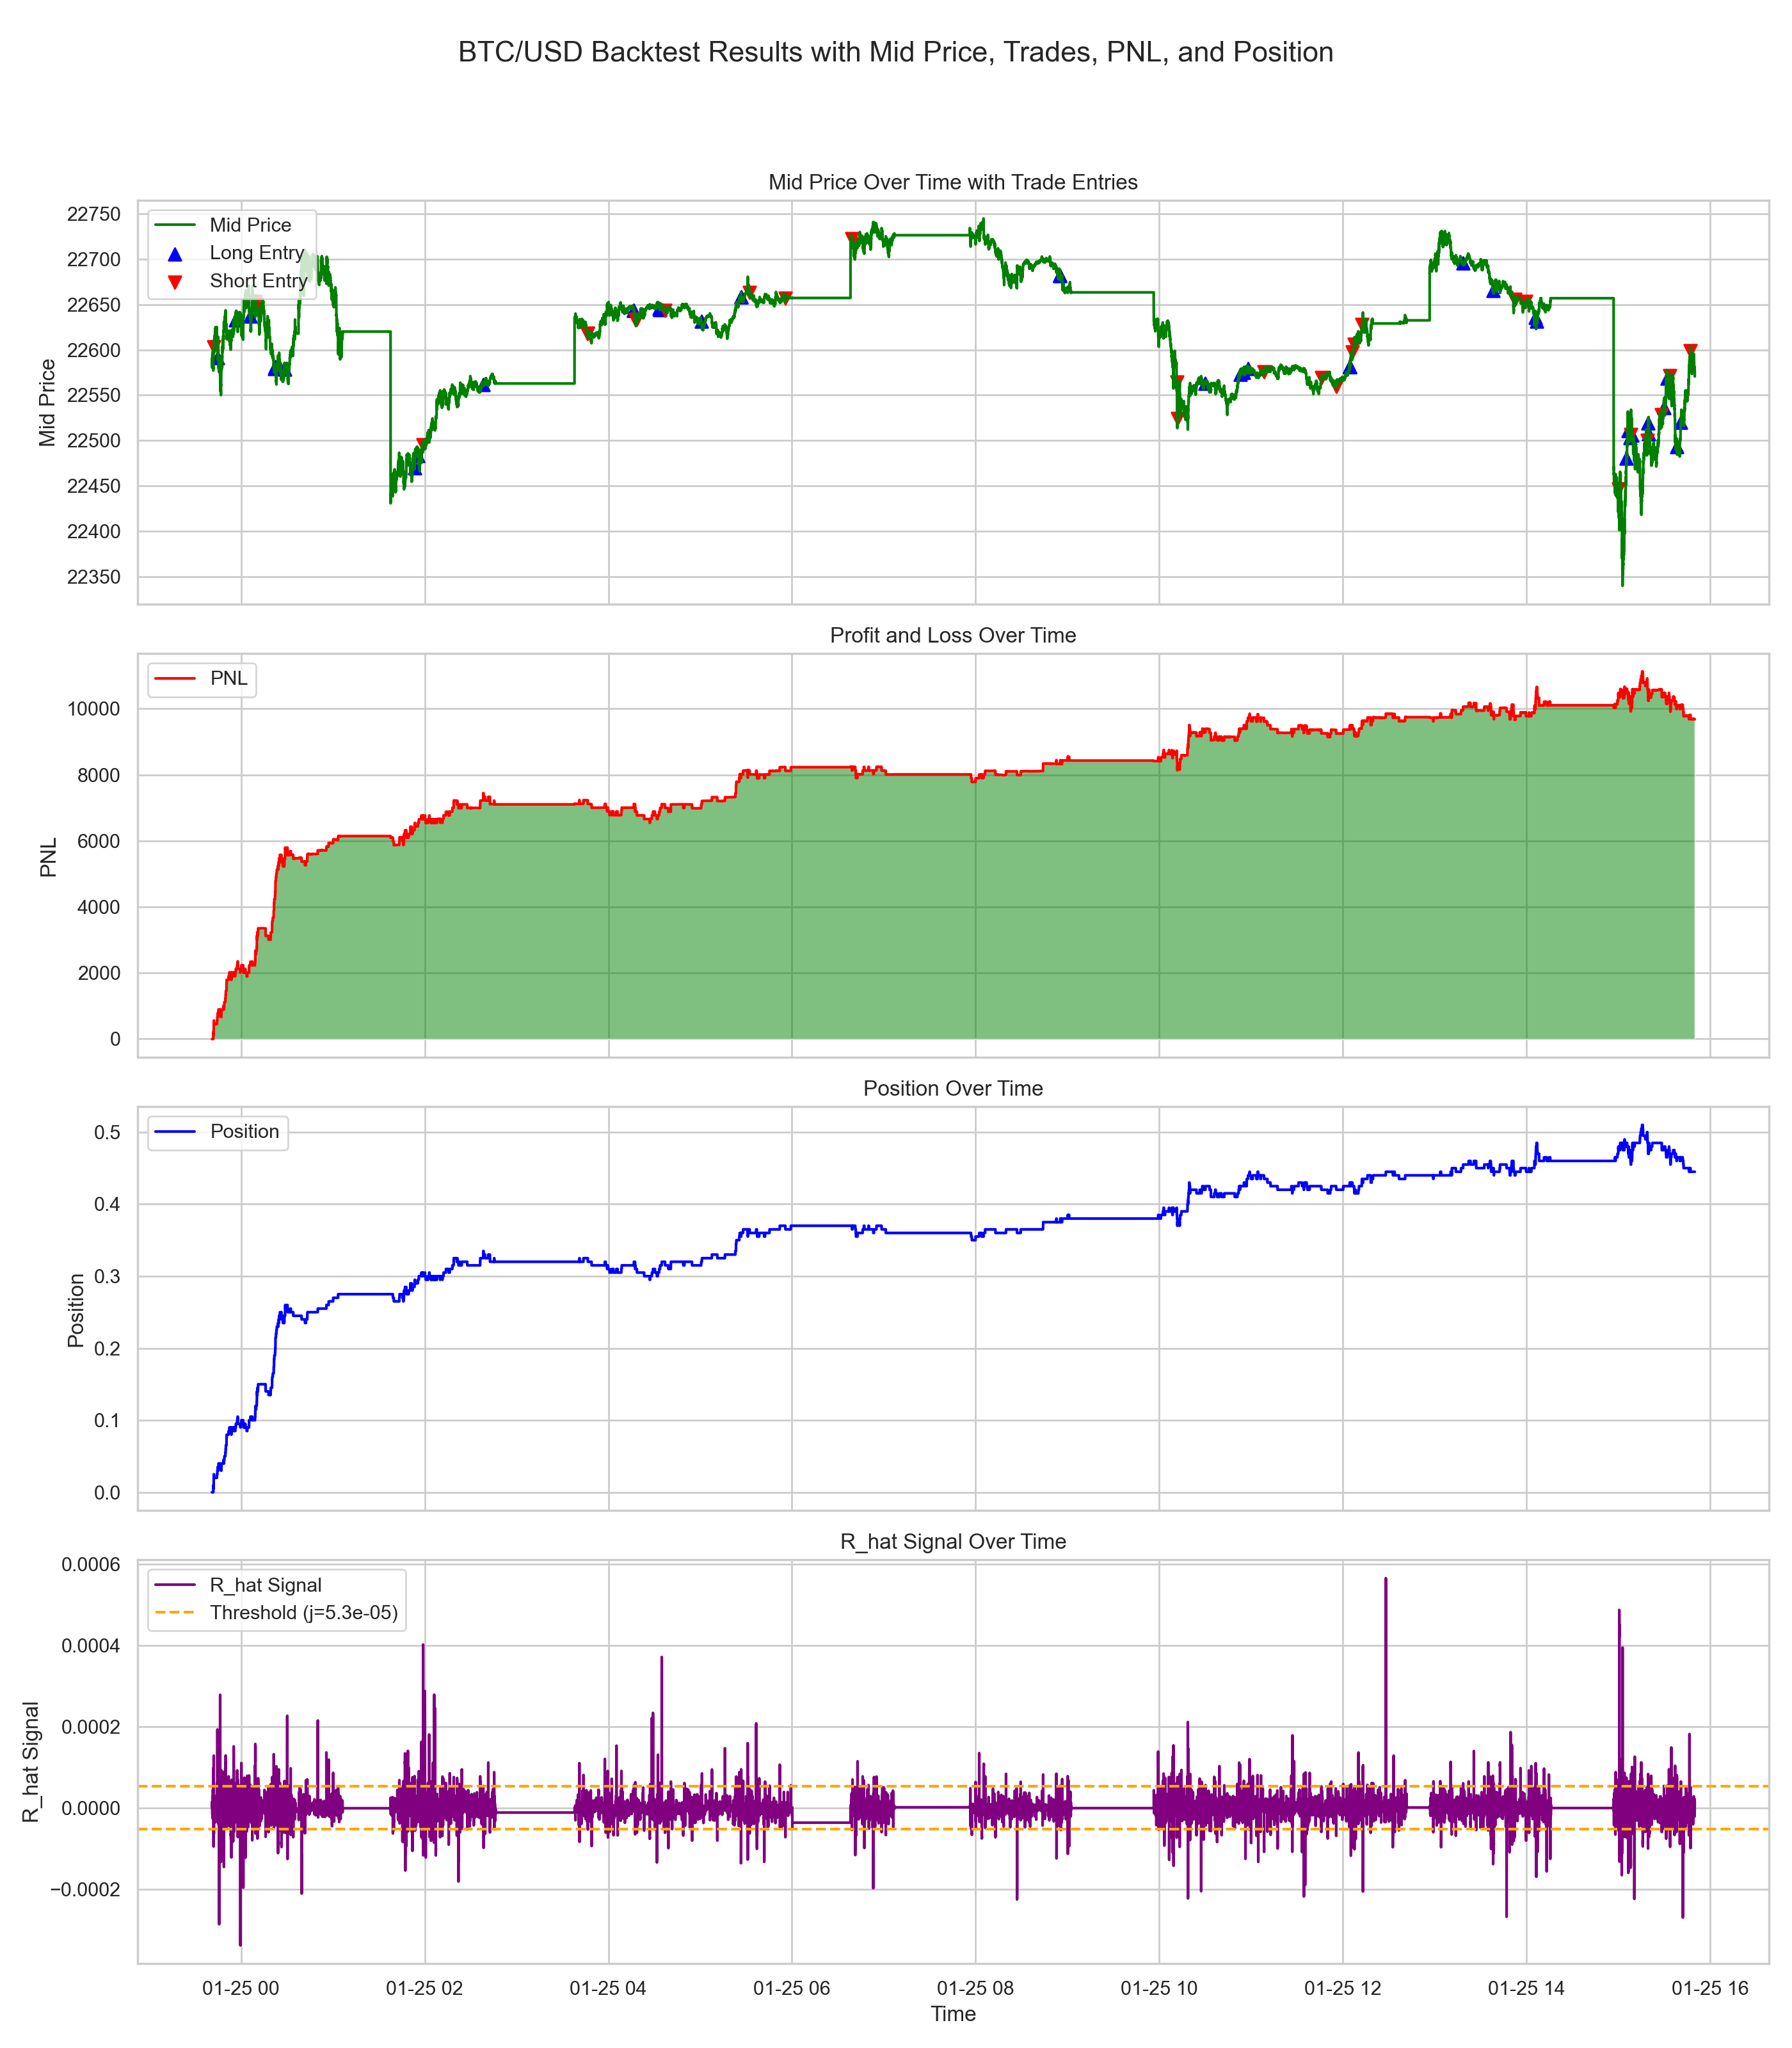

In [441]:
plot_backtest_results_with_trades_and_signal_and_position(adj_BTC_USD_backtest_data, adj_BTC_USD_book_test, j, title='BTC/USD Backtest Results with Mid Price, Trades, PNL, and Position')

## ETH/USD Inital Results

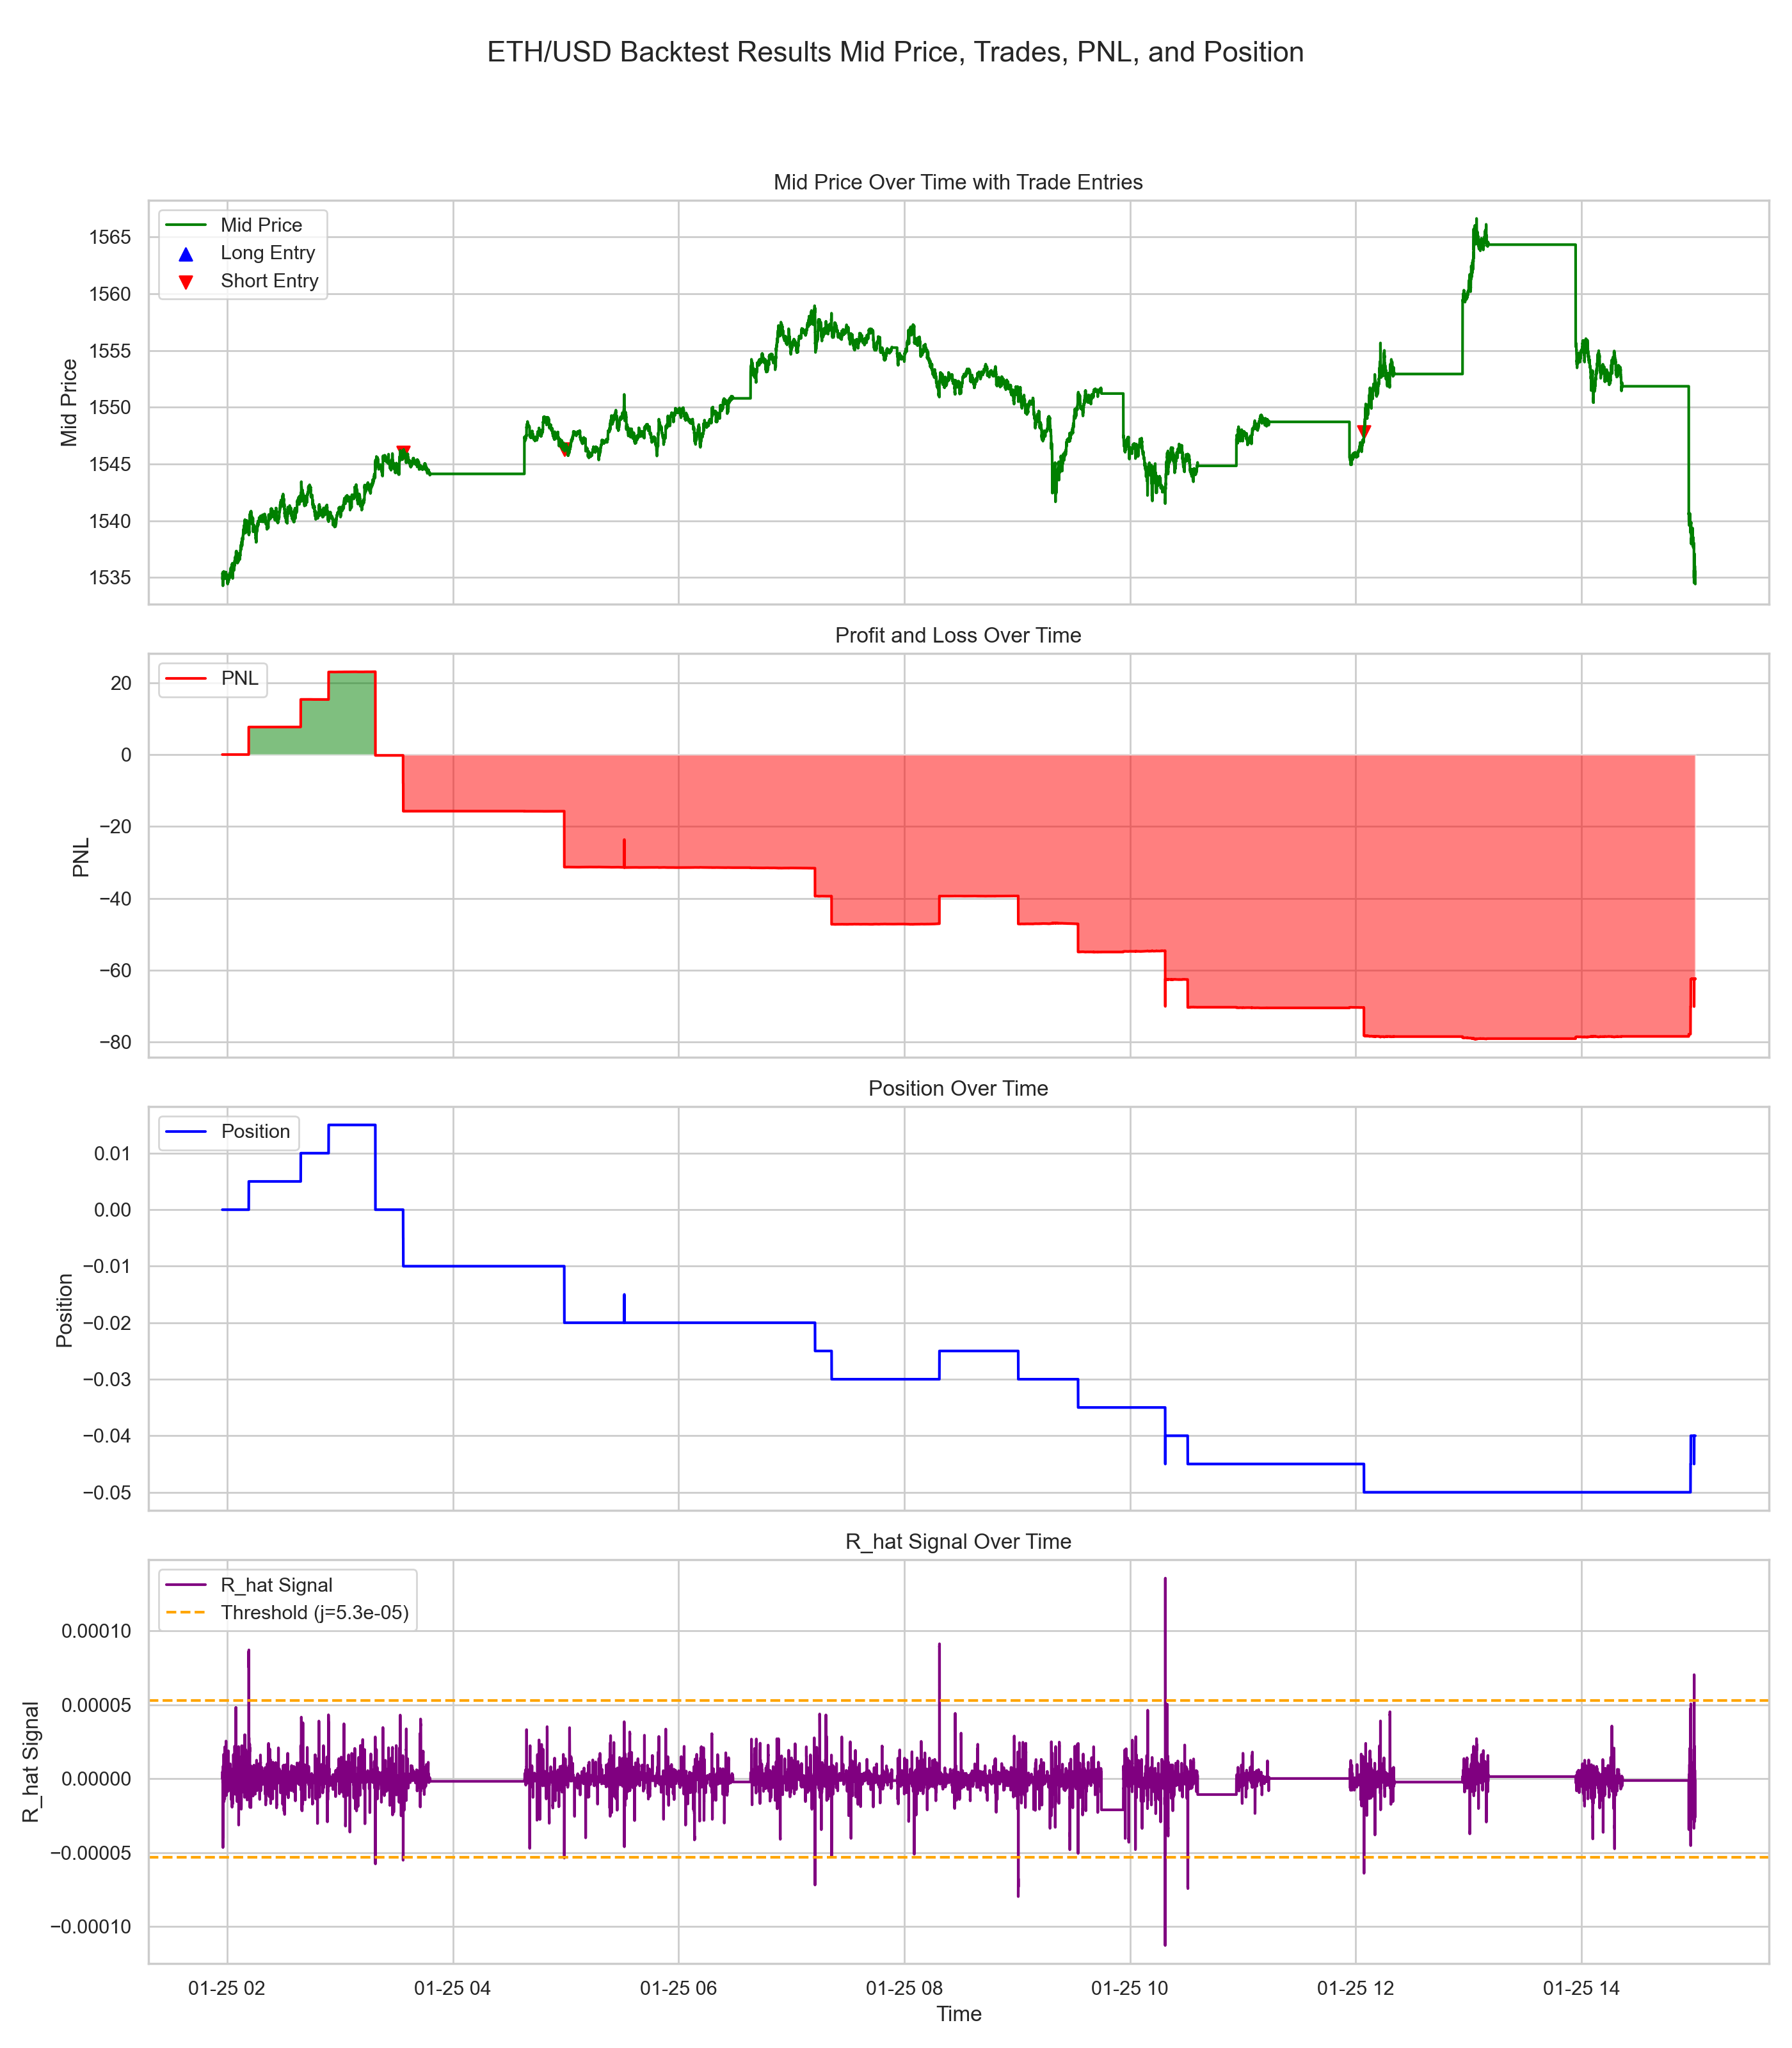

In [442]:
plot_backtest_results_with_trades_and_signal_and_position(adj_ETH_USD_backtest_data, adj_ETH_USD_book_test, j, title='ETH/USD Backtest Results Mid Price, Trades, PNL, and Position')

## ETH/BTC Inital Results

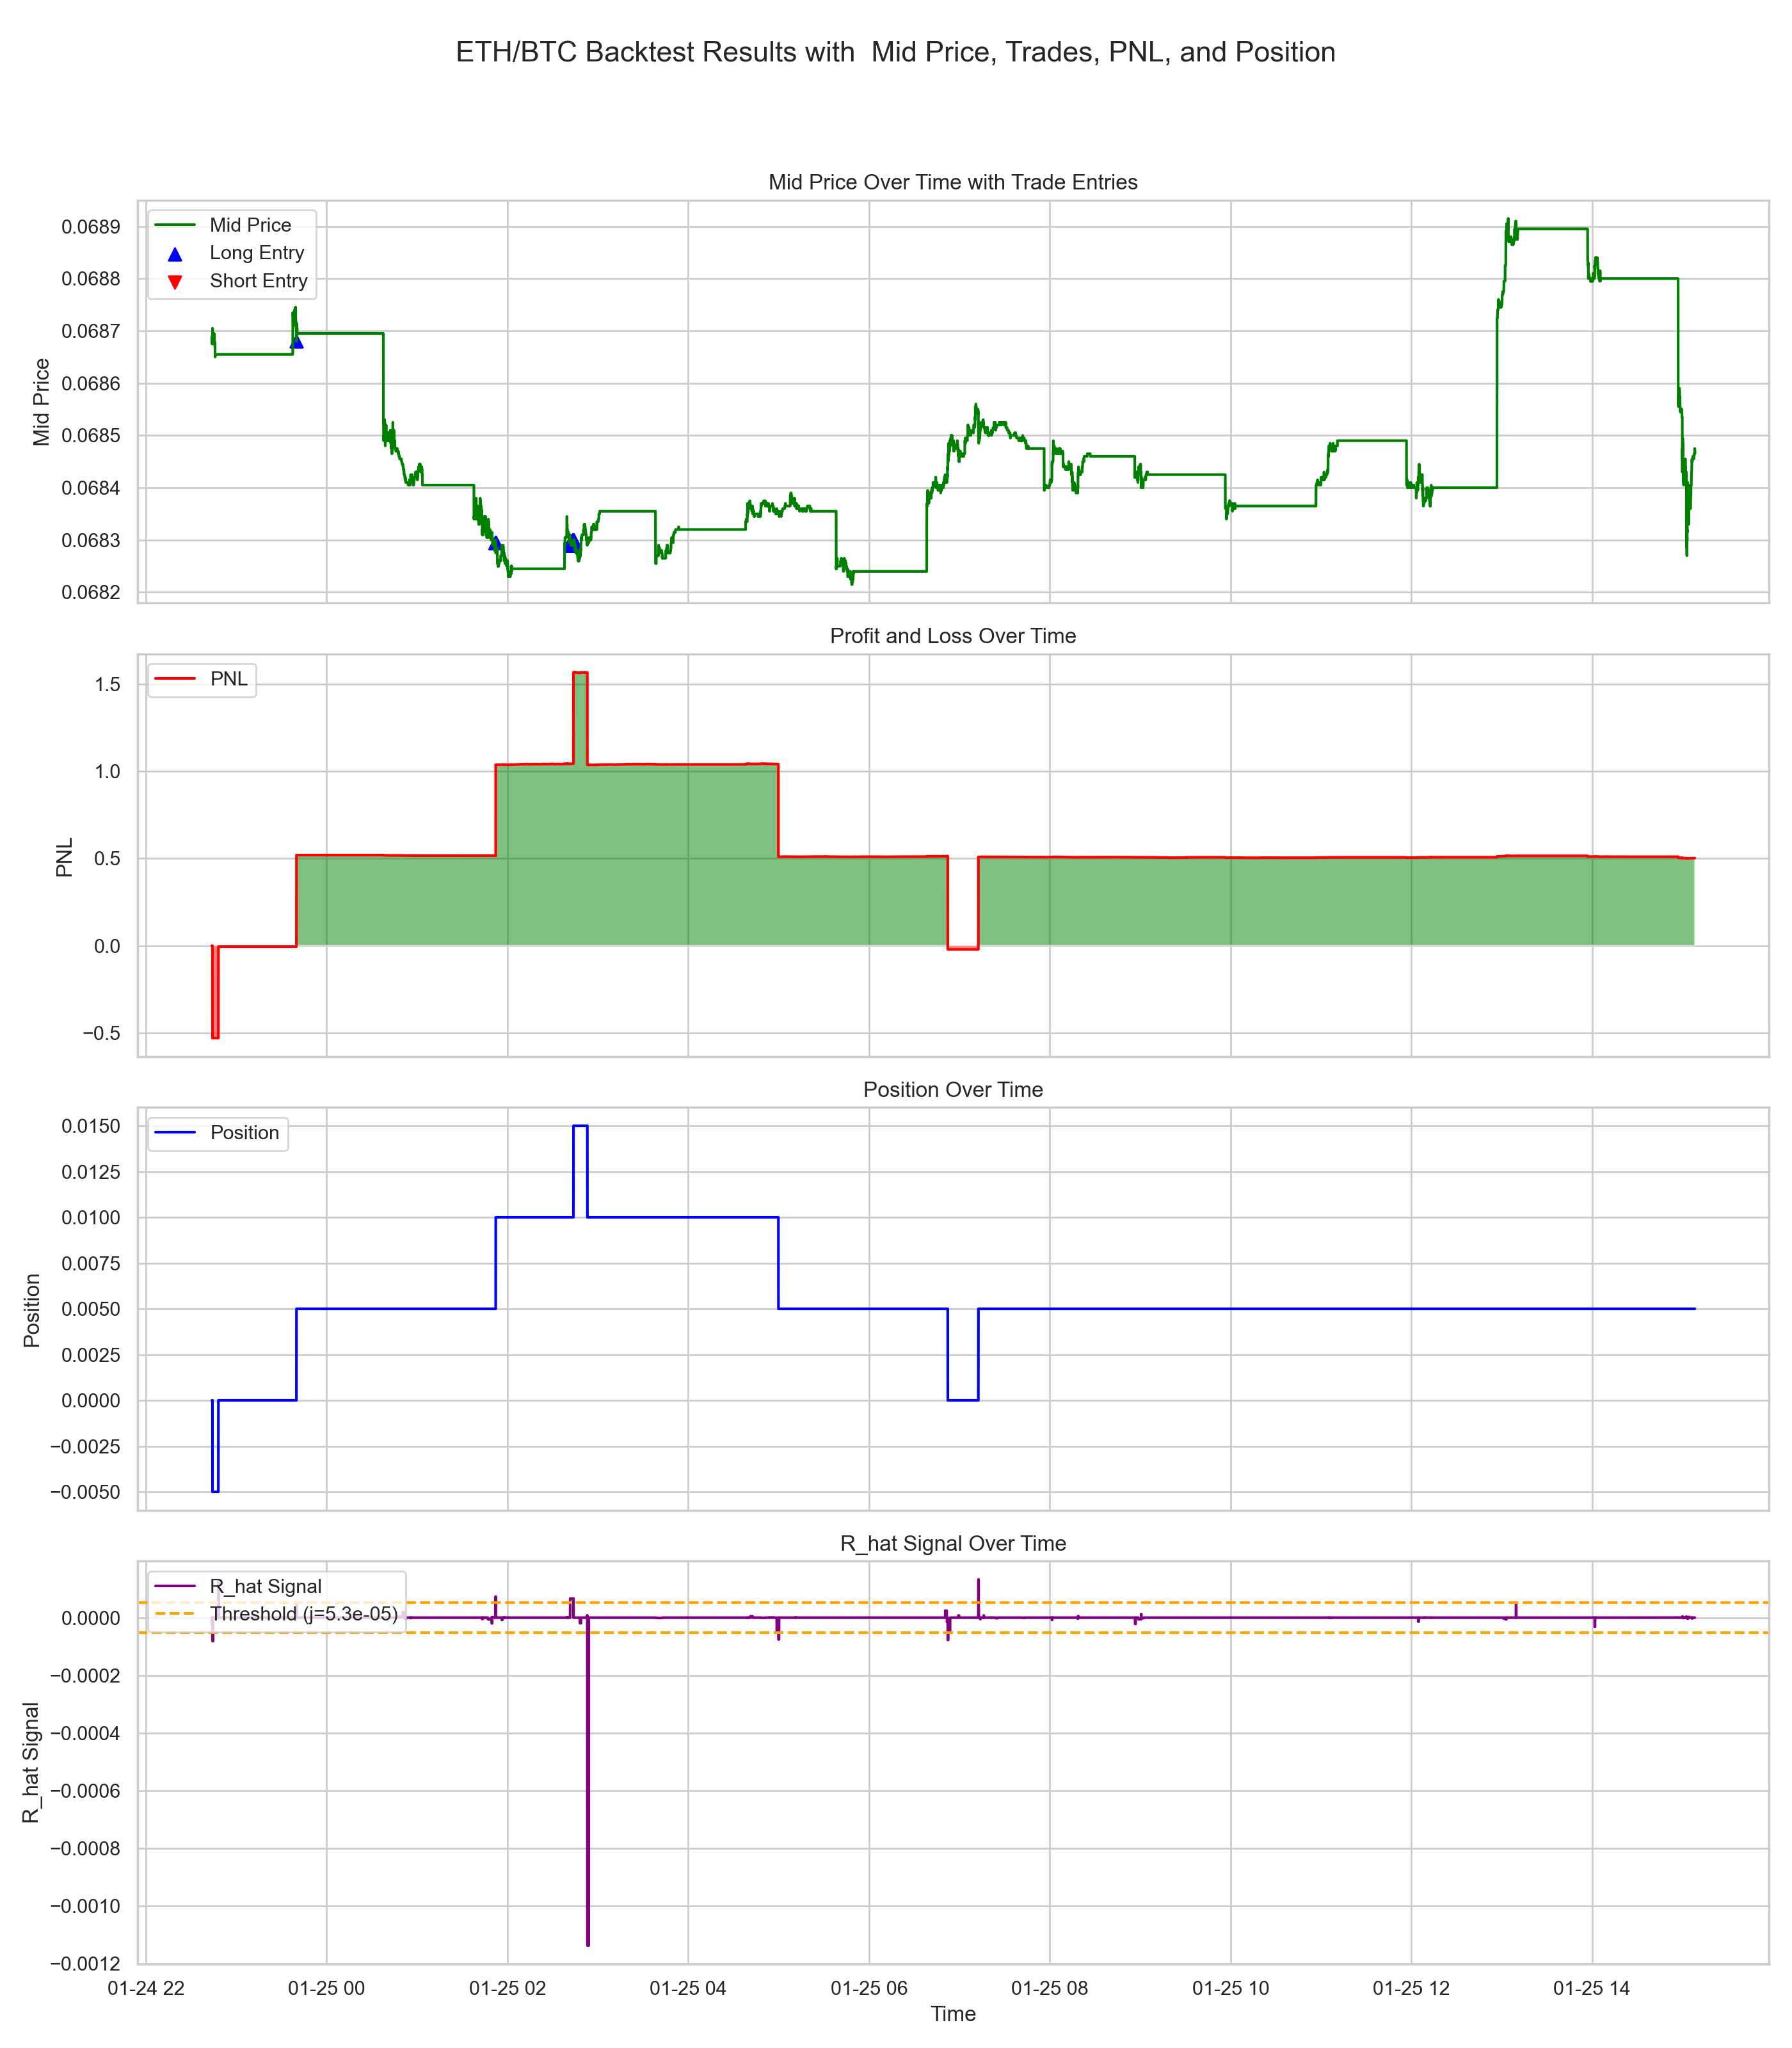

In [443]:
plot_backtest_results_with_trades_and_signal_and_position(adj_ETH_BTC_backtest_data, adj_ETH_BTC_book_test, j, title='ETH/BTC Backtest Results with  Mid Price, Trades, PNL, and Position')

# Hyper Parameter optmization

In [458]:
def calc_indicators(trade_data_train, trade_data_test, book_data_train, book_data_test, Tau, T):
    """
    Calculates trading indicators based on trade flow, integrity checks, forward returns, 
    and generates a beta matrix for predictions.

    Parameters:
    - trade_data_train: DataFrame with training trade data.
    - trade_data_test: DataFrame with testing trade data.
    - book_data_train: DataFrame with training book data.
    - book_data_test: DataFrame with testing book data.
    - Tau: Single tau value for calculating trade flow.
    - T: Single T value for calculating forward return.

    Returns:
    - trade_data_test_fitted: DataFrame of testing trade data with predictions and 'T_pre' column.
    """
    # Calculate trade flow and check integrity for both training and testing trade data
    Calculate_Trade_Flow(trade_data_train, Tau)  # Tau is already a list here
    check_dataframe_integrity(trade_data_train, set_0=True)
    Calculate_Trade_Flow(trade_data_test, Tau)
    check_dataframe_integrity(trade_data_test, set_0=True)
    
    # Calculate forward return for both training and testing data frames
    Calculate_Forward_Return(trade_data_train, book_data_train, [T])
    Calculate_Forward_Return(trade_data_test, book_data_test, [T])
    
    # Generate beta matrix from training trade data and apply predictions to testing trade data
    beta_matrix = generate_beta_matrix(trade_data_train)
    trade_data_test_fitted = Calculate_Predictions(trade_data_test, beta_matrix)
    trade_data_test_fitted['T_pre'] = trade_data_test_fitted.index  # Add 'T_pre' column
    
    return trade_data_test_fitted

def run_strategy(trade_data_test_fitted, book_data_test, j, zeta, trade_size,settle_ETH = None):
    """
    Executes the trading strategy by running a backtest on the fitted testing trade data.

    Parameters:
    - trade_data_test_fitted: DataFrame with fitted testing trade data.
    - book_data_test: DataFrame with testing book data.
    - j, zeta, trade_size: Parameters for backtesting.

    Returns:
    - adj_backtest_data: Adjusted backtest data.
    - adj_book_test: Adjusted book test data.
    """
    final_pnl, backtest_data = Run_Backtest(trade_data_test_fitted, book_data_test, j, zeta, trade_size)
    final_pnl, adj_backtest_data, adj_book_test,cont_mid = regularize_backtest_data(trade_data_test_fitted, book_data_test,settle_ETH)
    
    return final_pnl, adj_backtest_data, adj_book_test

def optimized_grid_search(trade_data_train, trade_data_test, book_data_train, book_data_test, tau_range, t_range, j_range, zeta_range, trade_size_range, settle_ETH = None):
    best_score = float('-inf')
    best_params = {}
    best_backtest_data = adj_backtest_data
    best_book_data = adj_book_test
    # Pre-calculate indicators for each Tau and T combination
    precalculated_data = {}
    for Tau in tau_range:
        for T in t_range:
            key = (Tau, T)
            precalculated_data[key] = calc_indicators(trade_data_train, trade_data_test, book_data_train, book_data_test, [Tau], T)

    # Iterate over j, zeta, and trade_size parameters
    for (Tau, T), trade_data_test_fitted in precalculated_data.items():
        for j in j_range:
            for zeta in zeta_range:
                for trade_size in trade_size_range:
                    
                    final_pnl, adj_backtest_data, adj_book_test = run_strategy(trade_data_test_fitted, book_data_test, j, zeta, trade_size, settle_ETH)
                    # Assume calculation of final pnl or another metric from adj_backtest_data
                    score = final_pnl  # Replace with actual score calculation
                    
                    if score > best_score:
                        best_score = score
                        best_params = {'Tau': Tau, 'T': T, 'j': j, 'zeta': zeta, 'trade_size': trade_size}
                        best_backtest_data = adj_backtest_data
                        best_book_data = adj_book_test

    return best_params, best_score, best_backtest_data, best_book_data


In [466]:
# Parameter ranges for BTC_USD
tau_range_btc_usd = [5, 10, 30]
t_range_btc_usd = [1, 5, 10]
j_range_btc_usd = [0.0001, 0.0005, 0.001, 0.5]
zeta_range_btc_usd = [0, 0.005]
trade_size_range_btc_usd = [0.005, 0.05]


# Run optimization for BTC_USD
btc_usd_best_params, btc_usd_best_score, btc_usd_best_backtest_data , btc_usd_best_book_data= optimized_grid_search(
    BTC_USD_trades_train, BTC_USD_trades_test,
    BTC_USD_book_train, BTC_USD_book_test,
    tau_range_btc_usd, t_range_btc_usd, j_range_btc_usd, zeta_range_btc_usd, trade_size_range_btc_usd
)


Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 15 NaN value(s), which is 0.01% of the rows.
Filling all NaN values with 0.0
Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 9 NaN value(s), which is 0.00% of the rows.
Filling all NaN values with 0.0


C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is

In [464]:
print("BTC_USD Best Params:", btc_usd_best_params)
print("BTC_USD Best Score:", btc_usd_best_score)

BTC_USD Best Params: {'Tau': 30, 'T': 1, 'j': 0.0001, 'zeta': 0, 'trade_size': 0.05}
BTC_USD Best Score: 44012.67975000002


In [472]:

# Parameter ranges for ETH_USD
tau_range_eth_usd =  [5, 10, 30]
t_range_eth_usd = [1, 5, 10]
j_range_eth_usd = [0.0001, 0.0005, 0.001, 0.5]
zeta_range_eth_usd = [0, 0.005]
trade_size_range_eth_usd = [0.005, 0.05]

# Run optimization for ETH_USD
eth_usd_best_params, eth_usd_best_score , eth_usd_best_backtest_data , eth_usd_best_book_data = optimized_grid_search(
    ETH_USD_trades_train, ETH_USD_trades_test,
    ETH_USD_book_train, ETH_USD_book_test,
    tau_range_eth_usd, t_range_eth_usd, j_range_eth_usd, zeta_range_eth_usd, trade_size_range_eth_usd
)



Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 24 NaN value(s), which is 0.02% of the rows.
Filling all NaN values with 0.0
Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 11 NaN value(s), which is 0.01% of the rows.
Filling all NaN values with 0.0


C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is

In [ ]:
print("ETH_USD Best Params:", eth_usd_best_params)
print("ETH_USD Best Score:", eth_usd_best_score)

In [448]:
print("ETH_USD Best Params:", eth_usd_best_params)
print("ETH_USD Best Score:", eth_usd_best_score)

ETH_USD Best Params: {'Tau': 10, 'T': 10, 'j': 0.0001, 'zeta': 0, 'trade_size': 0.05}
ETH_USD Best Score: 306.886


In [479]:

# Parameter ranges for ETH_BTC
tau_range_eth_btc = [5, 10, 30]
t_range_eth_btc = [1, 5, 10]
j_range_eth_btc = [0.0001, 0.0005, 0.001, 0.5]
zeta_range_eth_btc = [0, 0.005]
trade_size_range_eth_btc = [0.005, 0.05]

# Run optimization for ETH_BTC
eth_btc_best_params, eth_btc_best_score, eth_btc_best_backtest_data , btc_usd_best_book_data= optimized_grid_search(
    ETH_BTC_trades_train, ETH_BTC_trades_test,
    ETH_BTC_book_train, ETH_BTC_book_test,
    tau_range_eth_btc, t_range_eth_btc, j_range_eth_btc, zeta_range_eth_btc, trade_size_range_eth_btc, adj_ETH_USD_book_test
)

Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 494 NaN value(s), which is 42.84% of the rows.
Filling all NaN values with 0.0
Check for excessively large numbers: Passed
Check for NaN values: Found. Detailed report follows.
Column 'F' has 414 NaN value(s), which is 51.43% of the rows.
Filling all NaN values with 0.0


C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jackm\AppData\Local\Temp\ipykernel_66960\3950572349.py:47: SettingWithCopyWarning: 
A value is

In [452]:
print("ETH_BTC Best Params:", eth_btc_best_params)
print("ETH_BTC Best Score:", eth_btc_best_score)

ETH_BTC Best Params: {'Tau': 5, 'T': 1, 'j': 0.0001, 'zeta': 0, 'trade_size': 0.05}
ETH_BTC Best Score: 5.287354065


## Run Best Strategies

BTC_USD Final PNL: 0.0


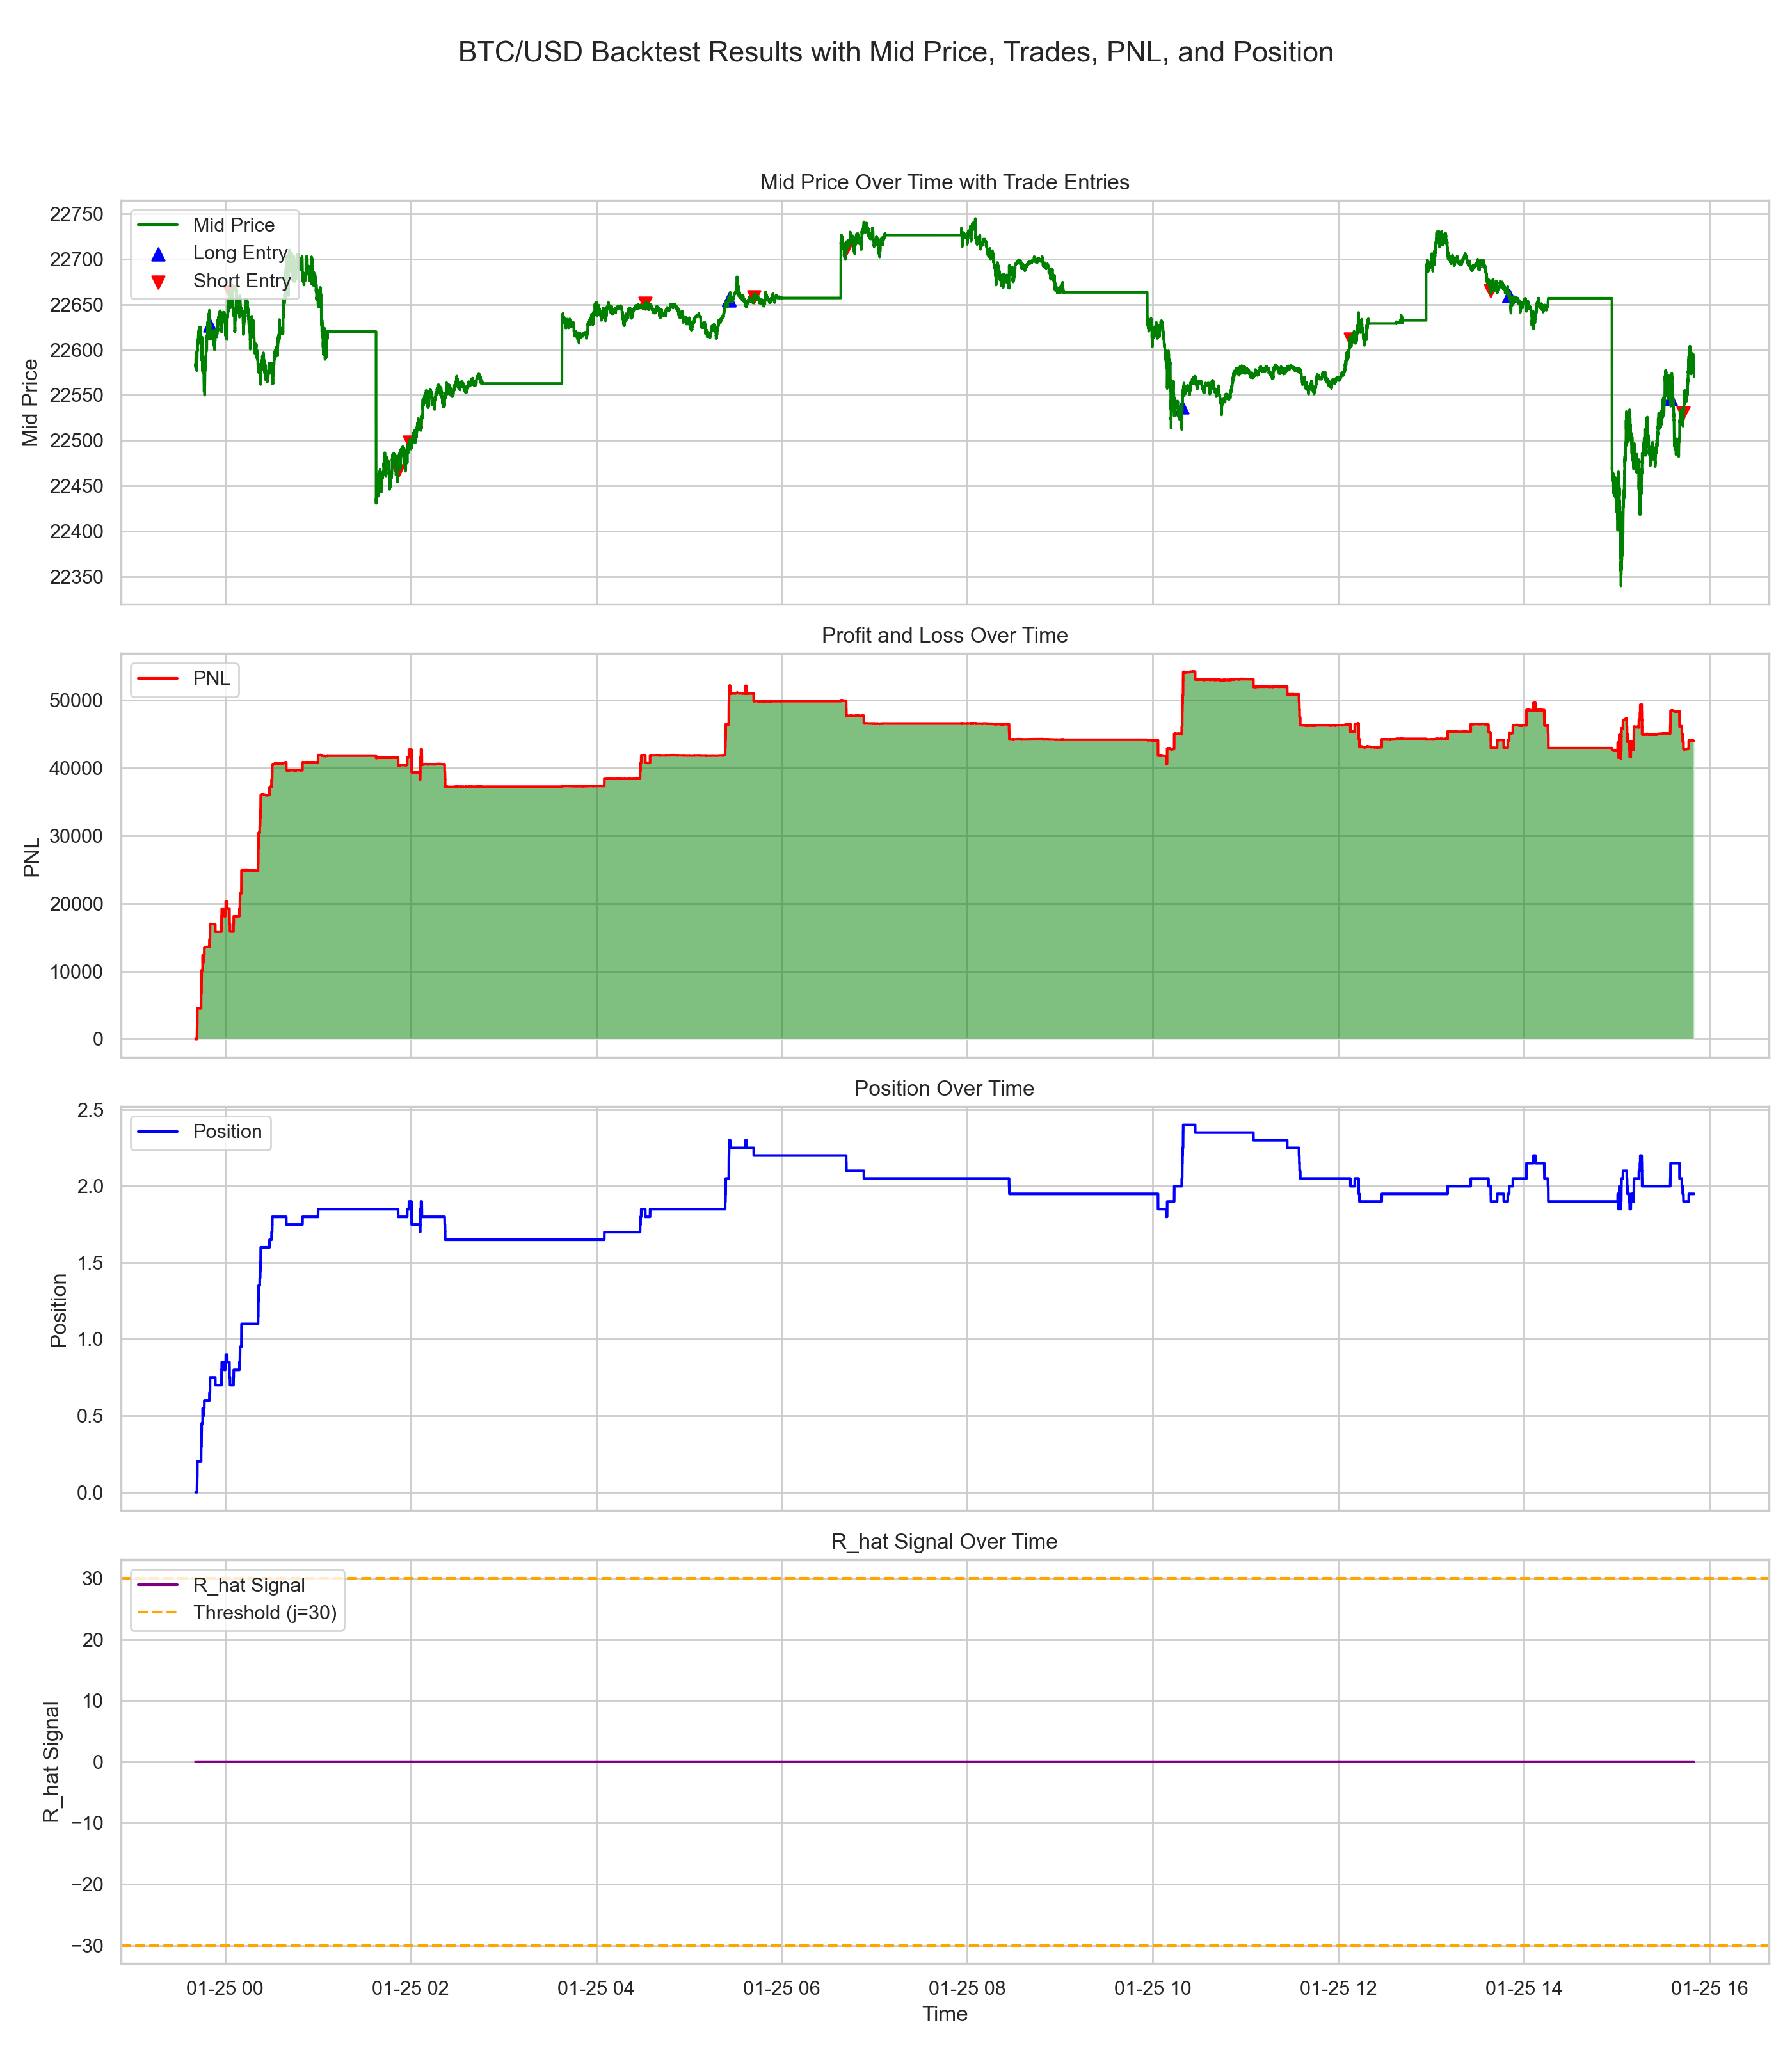

In [467]:
j = btc_usd_best_params['Tau']
trade_cost = btc_usd_best_params['zeta']
trade_size = btc_usd_best_params['trade_size']
#BTC_USD_final_pnl, adj_BTC_USD_backtest_data, adj_BTC_USD_book_test = run_strategy(btc_usd_best_backtest_data , btc_usd_best_book_data, j, trade_cost, trade_size)

print(f"BTC_USD Final PNL: {BTC_USD_final_pnl}")
plot_backtest_results_with_trades_and_signal_and_position(btc_usd_best_backtest_data, btc_usd_best_book_data, j, title='BTC/USD Backtest Results with Mid Price, Trades, PNL, and Position')

ETH_USD Final PNL: -62.3814495


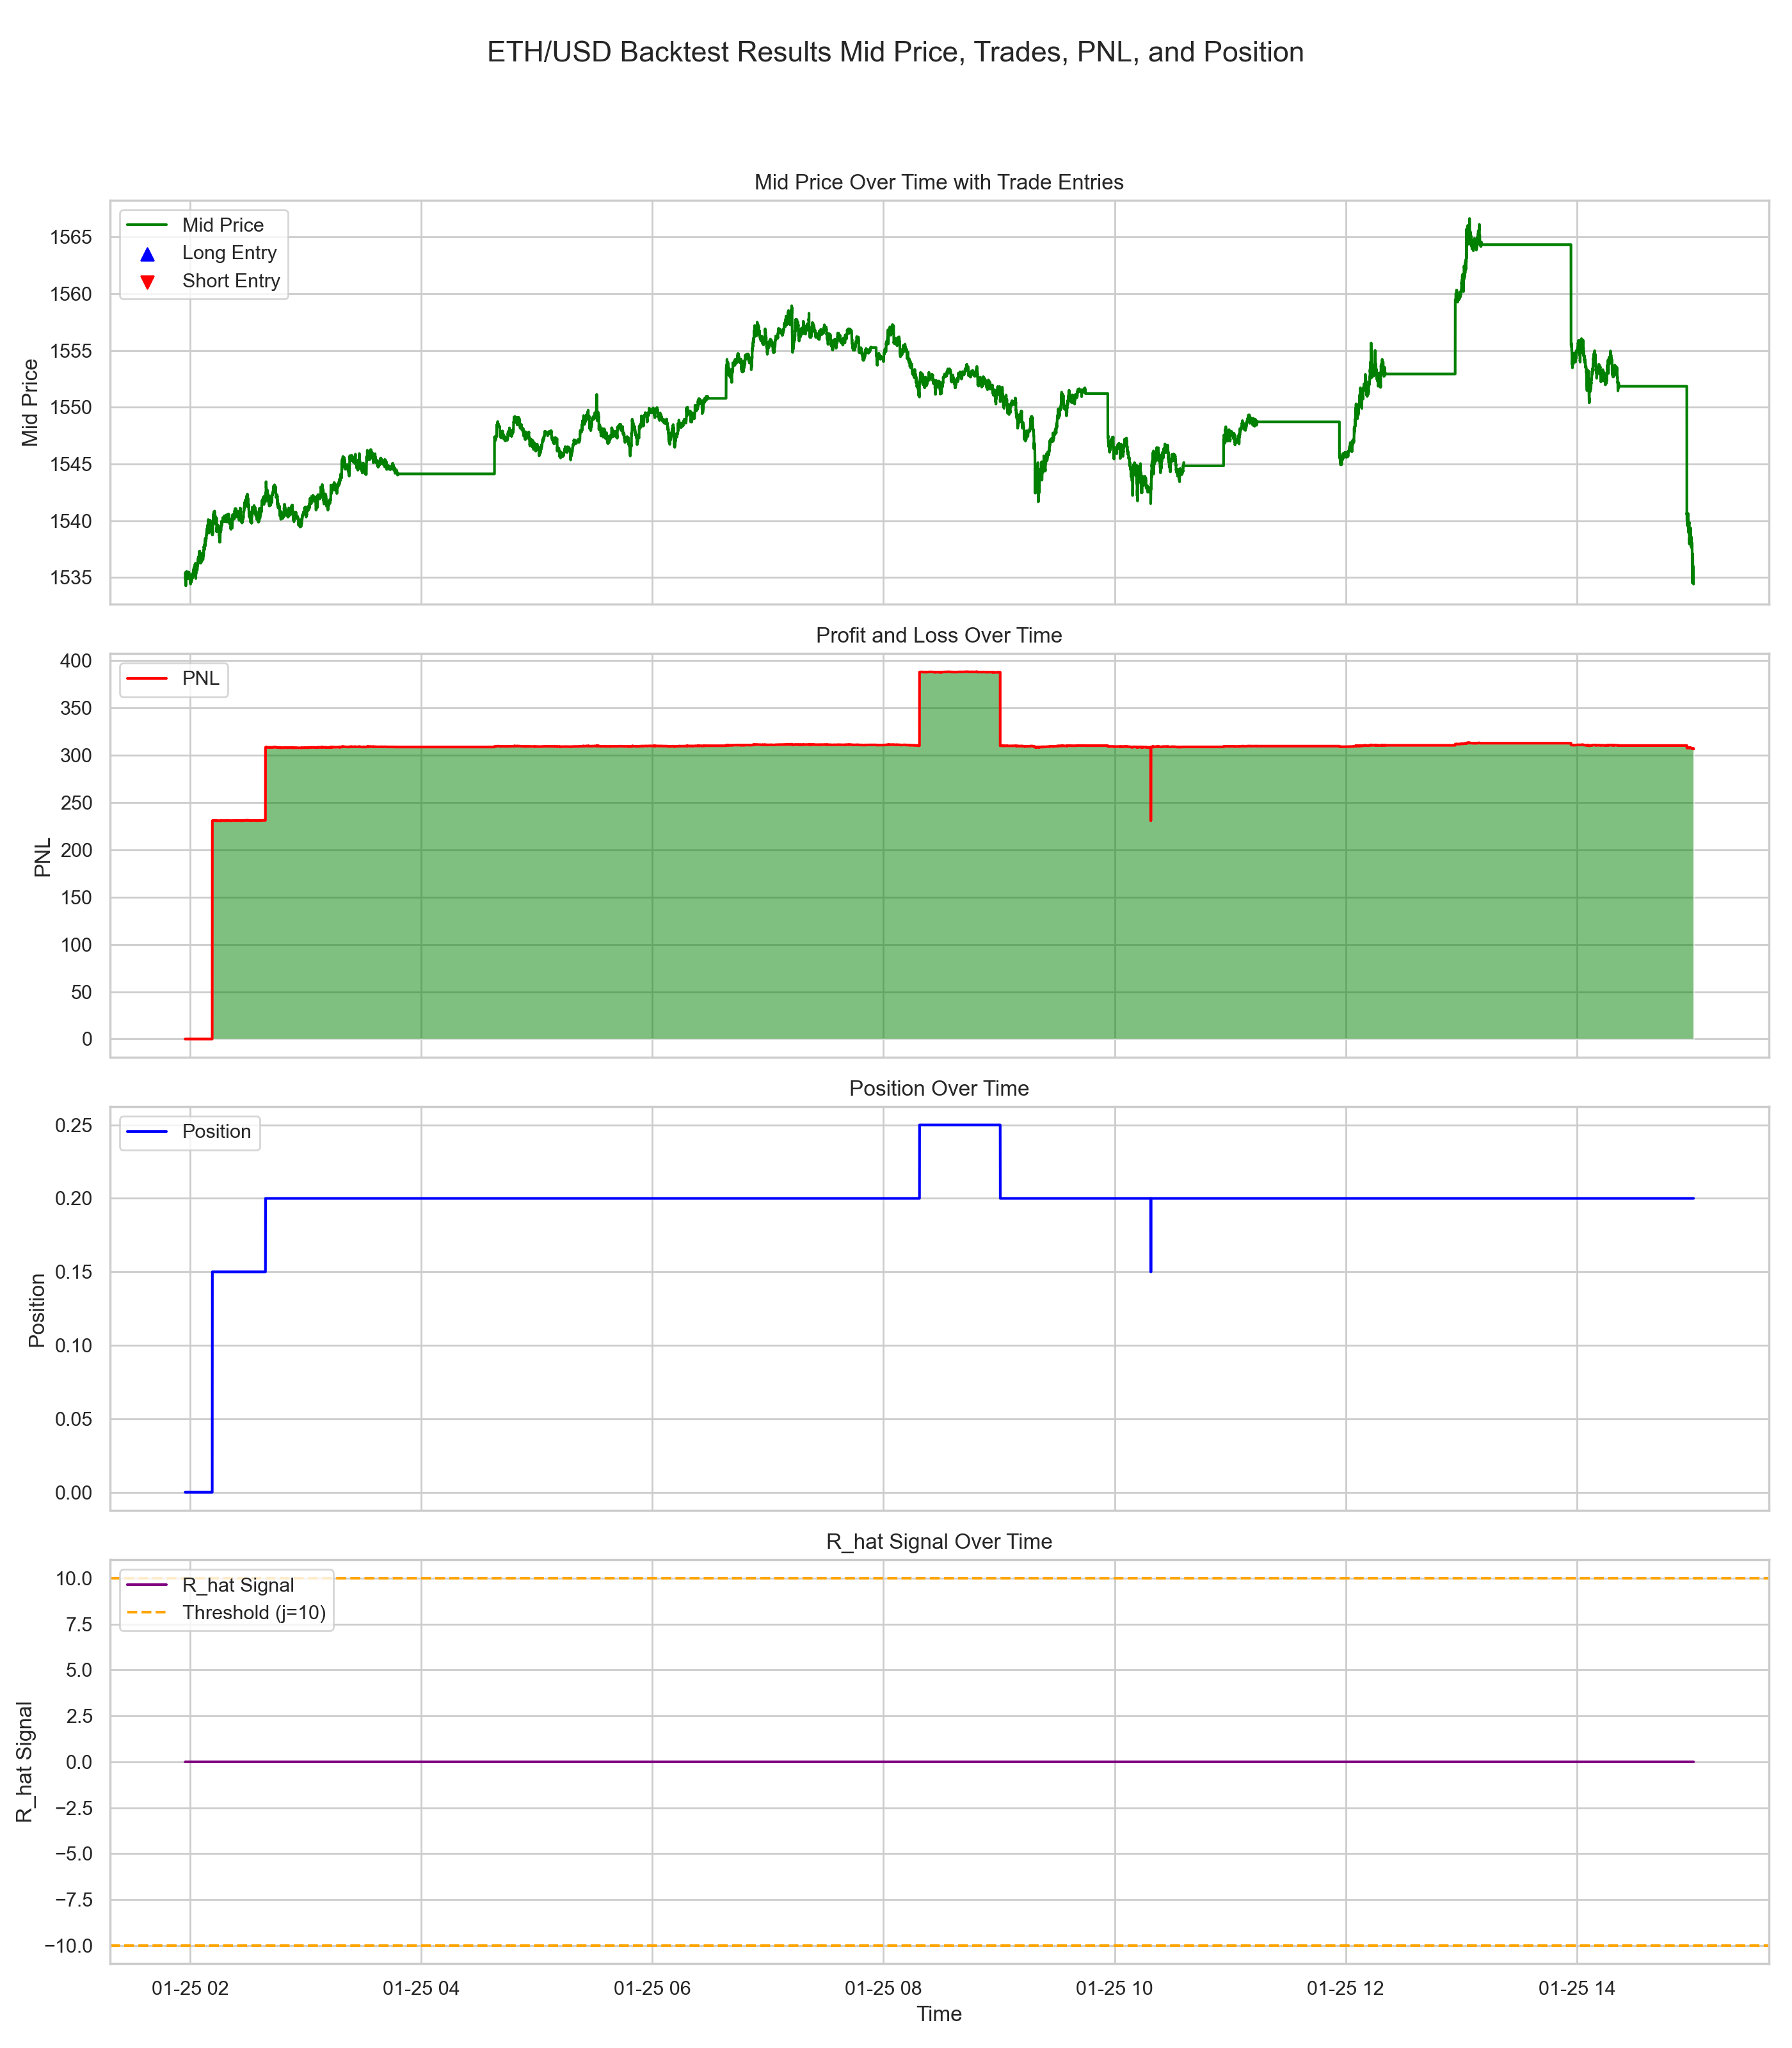

In [475]:

j = eth_usd_best_params['Tau']
trade_cost = eth_usd_best_params['zeta']
trade_size = eth_usd_best_params['trade_size']
#BTC_USD_final_pnl, adj_ETH_USD_backtest_data, adj_ETH_USD_book_test,mid_cont_ETH_USD = run_strategy(ETH_USD_trades_test_fitted, ETH_USD_book_test, j, trade_cost, trade_size)
print(f"ETH_USD Final PNL: {ETH_USD_final_pnl}")
plot_backtest_results_with_trades_and_signal_and_position(eth_usd_best_backtest_data , eth_usd_best_book_data, j, title='ETH/USD Backtest Results Mid Price, Trades, PNL, and Position')


ETH_BTC Final PNL: 0.0


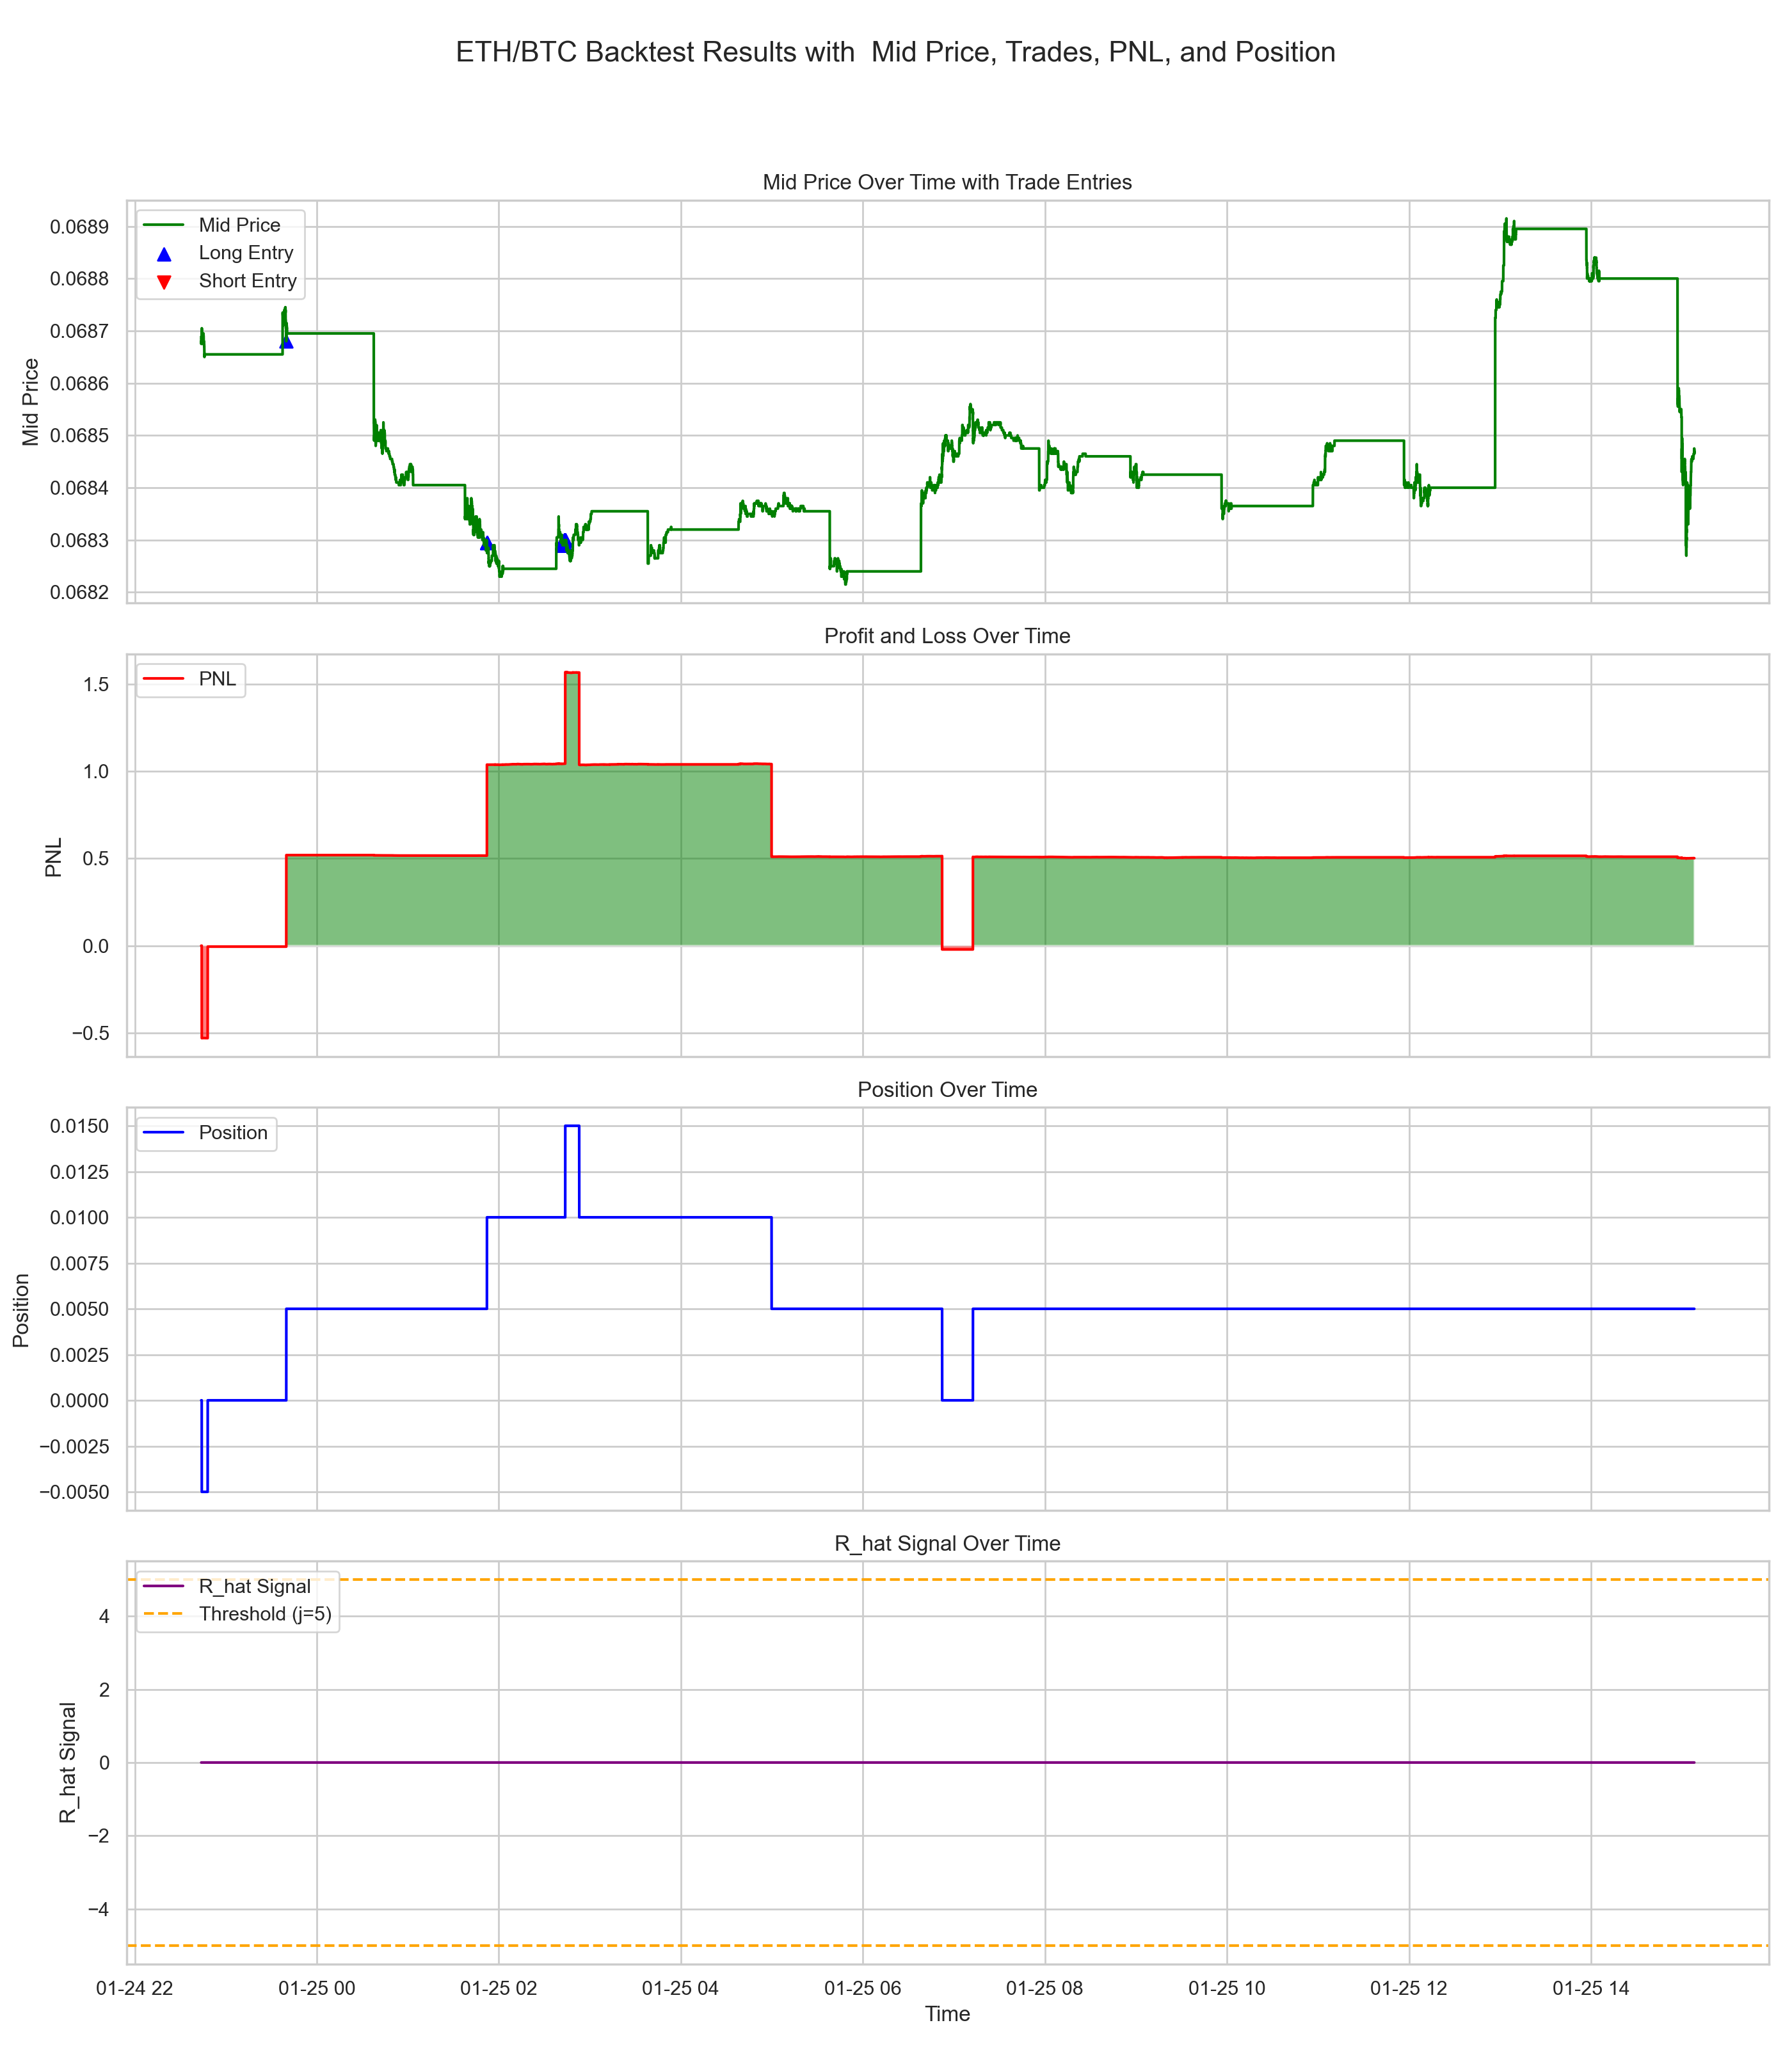

In [481]:

j = eth_btc_best_params['Tau']
trade_cost = eth_btc_best_params['zeta']
trade_size = eth_btc_best_params['trade_size']

print(f"ETH_BTC Final PNL: {BTC_USD_final_pnl}")
plot_backtest_results_with_trades_and_signal_and_position(adj_ETH_BTC_backtest_data, adj_ETH_BTC_book_test, j, title='ETH/BTC Backtest Results with  Mid Price, Trades, PNL, and Position')


# 5) Analysis

from what I can see flow is not a good indicator of future retuns. 

In [482]:
def calculate_pnl_statistics(pnl_df):
    # Calculate daily returns from PNL
    daily_returns = pnl_df['PNL'].diff().dropna()

    # Summary Statistics
    summary_stats = daily_returns.describe()

    # Maximum Drawdown
    cumulative_returns = (1 + daily_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Sharpe Ratio (assuming risk-free rate = 0 for simplicity)
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)  # Annualizing Sharpe Ratio

    # Display results
    print("Summary Statistics for PNL:")
    display(summary_stats.to_frame())  # Convert Series to DataFrame for nicer display
    
    print("\nMaximum Drawdown: {:.2%}".format(max_drawdown))
    
    print("\nSharpe Ratio: {:.2f}".format(sharpe_ratio))

calculate_pnl_statistics(btc_usd_best_backtest_data)

Summary Statistics for PNL:


c:\Users\jackm\anaconda3\envs\QTSHW3-2\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
c:\Users\jackm\anaconda3\envs\QTSHW3-2\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate


,PNL
count,58147.000000
mean,0.756921
std,64.965962
min,-2267.943750
25%,-0.391000
50%,0.000000
75%,0.492500
max,2269.505000



Maximum Drawdown: -inf%

Sharpe Ratio: 0.18


In [483]:
calculate_pnl_statistics(eth_usd_best_backtest_data)

Summary Statistics for PNL:


,PNL
count,46983.000000
mean,0.006532
std,1.007785
min,-77.633500
25%,-0.002000
50%,0.000000
75%,0.002000
max,77.643750



Maximum Drawdown: -3358.95%

Sharpe Ratio: 0.10


# 6) Conclusion

This doesnt seem to be a great strategy. I did use the more conservative approach and it does look like it worked for BTC_USD probably because there is alot of momentum but it was bad for the other ones

# 7) Limitations

Time, I would have created better summary stats statistics since i had my data perfectly regulairzed. I did all the extra steps to make it more realistic but ran out of time for a very indepth anlysis. I would have loved to explore what different traning and testing data sets did to the data.